# Telecom Churn Case Study

### Problem Statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
For many incumbent operators, retaining high profitable customers is the number one business goal.

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

We need to analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

### Understanding and Defining Churn

There are two main models of payment in the telecom industry - <b>postpaid</b> (customers pay a monthly/annual bill after using the services) and <b>prepaid</b>(customers pay/recharge with a certain amount in advance and then use the services).

In the postpaid model, when customers want to switch to another operator, they usually inform the existing operator to terminate the services, and you directly know that this is an instance of churn.

However, in the prepaid model, customers who want to switch to another network can simply stop using the services without any notice, and it is hard to know whether someone has actually churned or is simply not using the services temporarily (e.g. someone may be on a trip abroad for a month or two and then intend to resume using the services again).

Thus, churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully.  Also, prepaid is the most common model in India and southeast Asia, while postpaid is more common in Europe in North America.

This project is based on the Indian and Southeast Asian market.


### Definitions of Churn

This project is based on the usage-based churn which is defined as below :

<b>Usage-based churn</b>: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.

A potential shortcoming of this definition is that when the customer has stopped using the services for a while, it may be too late to take any corrective actions to retain them. For e.g., if you define churn based on a ‘two-months zero usage’ period, predicting churn could be useless since by that time the customer would have already switched to another operator.


### High-value Churn

In the Indian and the southeast Asian market, approximately 80% of revenue comes from the top 20% customers (called high-value customers). Thus, if we can reduce churn of the high-value customers, we will be able to reduce significant revenue leakage.

In this project, high-value customers based on a below definition : 

Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

<b>Note : It is required to predict churn only on high-value customers.</b>

## Steps Followed:
- Data Understanding
- Data Preparation
- Finding High Valued Customers
- EDA for High Valued Customers
- Model Building
- Important Churn Indicators
- Stratergies to manage customer churn

In [1]:
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV



pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

import warnings
warnings.filterwarnings('ignore')

## Data Understanding

In [2]:
## reading the data

data = pd.read_csv("telecom_churn_data.csv")
data.head(10)

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   
5     7000286308        109             0.0             0.0             0.0   
6     7001051193        109             0.0             0.0             0.0   
7     7000701601        109             0.0             0.0             0.0   
8     7001524846        109             0.0             0.0             0.0   
9     7001864400        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   
5            6/30/2014            7/31/2014            8/31/2014   
6            6/30/2014            7/31/2014            8/31/2014   
7            6/30/2014            7/31/2014            8/31/2014   
8            6/30/2014            7/31/2014            8/31/2014   
9            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9    arpu_6    arpu_7    arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014   197.385   214.816   213.803   21.100          NaN   
1            9/30/2014    34.047   355.074   268.321   86.285        24.11   
2            9/30/2014   167.690   189.058   210.226  290.714        11.54   
3            9/30/2014   221.338   251.102   508.054  389.500        99.91   
4            9/30/2014   261.636   309.876   238.174  163.426        50.31   
5            9/30/2014    50.258    58.810    83.386  170.826        50.16   
6            9/30/2014   429.023   190.704   255.114  114.751        71.03   
7            9/30/2014  1069.180  1349.850  3171.480  500.000        57.84   
8            9/30/2014   378.721   492.223   137.362  166.787       413.69   
9            9/30/2014   119.518   247.435   170.231  160.042        33.89   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   
5        43.63        85.48       138.79         19.28         13.44   
6        45.03        76.66        15.23        262.73         49.24   
7        54.68        52.29          NaN        453.43        567.16   
8       351.03        35.08        33.46         94.66         80.63   
9        30.11        22.43        27.84         63.48         54.16   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76           0.00           0.00           0.00   
2        208.36        118.91           0.00           0.00           0.00   
3         71.68        113.54           0.00          54.86          44.38   
4        124.26         45.81           0.00           0.00           0.00   
5         14.46         46.91           0.00           0.00           0.00   
6         92.08         50.33           0.00           0.00           0.00   
7        325.91           NaN          16.23          33.49          31.64   
8        136.48        108.71 

In [3]:
data.shape

(99999, 226)

In [4]:
data.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

In [5]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   mobile_number             int64  
 1   circle_id                 int64  
 2   loc_og_t2o_mou            float64
 3   std_og_t2o_mou            float64
 4   loc_ic_t2o_mou            float64
 5   last_date_of_month_6      object 
 6   last_date_of_month_7      object 
 7   last_date_of_month_8      object 
 8   last_date_of_month_9      object 
 9   arpu_6                    float64
 10  arpu_7                    float64
 11  arpu_8                    float64
 12  arpu_9                    float64
 13  onnet_mou_6               float64
 14  onnet_mou_7               float64
 15  onnet_mou_8               float64
 16  onnet_mou_9               float64
 17  offnet_mou_6              float64
 18  offnet_mou_7              float64
 19  offnet_mou_8              float64
 20  offnet_mou_9              f

In [6]:
data.describe()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  \
count   9.999900e+04    99999.0         98981.0         98981.0   
mean    7.001207e+09      109.0             0.0             0.0   
std     6.956694e+05        0.0             0.0             0.0   
min     7.000000e+09      109.0             0.0             0.0   
25%     7.000606e+09      109.0             0.0             0.0   
50%     7.001205e+09      109.0             0.0             0.0   
75%     7.001812e+09      109.0             0.0             0.0   
max     7.002411e+09      109.0             0.0             0.0   

       loc_ic_t2o_mou        arpu_6        arpu_7        arpu_8        arpu_9  \
count         98981.0  99999.000000  99999.000000  99999.000000  99999.000000   
mean              0.0    282.987358    278.536648    279.154731    261.645069   
std               0.0    328.439770    338.156291    344.474791    341.998630   
min               0.0  -2258.709000  -2014.045000   -945.808000  -1899.505000   
25%               0.0     93.411500     86.980500     84.126000     62.685000   
50%               0.0    197.704000    191.640000    192.080000    176.849000   
75%               0.0    371.060000    365.344500    369.370500    353.466500   
max               0.0  27731.088000  35145.834000  33543.624000  38805.617000   

        onnet_mou_6   onnet_mou_7   onnet_mou_8   onnet_mou_9  offnet_mou_6  \
count  96062.000000  96140.000000  94621.000000  92254.000000  96062.000000   
mean     132.395875    133.670805    133.018098    130.302327    197.935577   
std      297.207406    308.794148    308.951589    308.477668    316.851613   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        7.380000      6.660000      6.460000      5.330000     34.730000   
50%       34.310000     32.330000     32.360000     29.840000     96.310000   
75%      118.740000    115.595000    115.860000    112.130000    231.860000   
max     7376.710000   8157.780000  10752.560000  10427.460000   8362.360000   

       offnet_mou_7  offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  \
count  96140.000000  94621.000000  92254.000000   96062.000000   96140.000000   
mean     197.045133    196.574803    190.337222       9.950013       7.149898   
std      325.862803    327.170662    319.396092      72.825411      73.447948   
min        0.000000      0.000000      0.000000       0.000000       0.000000   
25%       32.190000     31.630000     27.130000       0.000000       0.000000   
50%       91.735000     92.140000     87.290000       0.000000       0.000000   
75%      226.815000    228.260000    220.505000       0.000000       0.000000   
max     9667.130000  14007.340000  10310.760000   13724.380000   15371.040000   

       roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  \
count   94621.000000   92254.000000   96062.000000   96140.000000   
mean        7.292981       6.343841      13.911337       9.818732   
std        68.402466      57.137537      71.443196      58.455762   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max     13095.360000    8464.030000    3775.110000    2812.040000   

       roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  loc_og_t2t_mou_7  \
count   94621.000000   92254.000000      96062.000000      96140.000000   
mean        9.971890       8.555519         47.100763         46.473010   
std        64.713221      58.438186        150.856393        155.318705   
min         0.000000       0.000000          0.000000          0.000000   
25%         0.000000       0.000000          1.660000          1.630000   
50%         0.000000       0.000000         11.910000         11.610000   
75%         0.000000       0.000000         40.960000         39.910000   
max      

In [7]:
# checking percentage of nulls across each variable columns
print(round(100*(data.isnull().sum()/len(data.index)), 2).sort_values(ascending = False))

count_rech_2g_6             74.85
date_of_last_rech_data_6    74.85
count_rech_3g_6             74.85
av_rech_amt_data_6          74.85
max_rech_data_6             74.85
total_rech_data_6           74.85
arpu_3g_6                   74.85
arpu_2g_6                   74.85
night_pck_user_6            74.85
fb_user_6                   74.85
arpu_3g_7                   74.43
count_rech_2g_7             74.43
fb_user_7                   74.43
count_rech_3g_7             74.43
arpu_2g_7                   74.43
av_rech_amt_data_7          74.43
max_rech_data_7             74.43
night_pck_user_7            74.43
total_rech_data_7           74.43
date_of_last_rech_data_7    74.43
night_pck_user_9            74.08
date_of_last_rech_data_9    74.08
fb_user_9                   74.08
arpu_2g_9                   74.08
max_rech_data_9             74.08
arpu_3g_9                   74.08
total_rech_data_9           74.08
av_rech_amt_data_9          74.08
count_rech_3g_9             74.08
count_rech_2g_

## Data Cleaning & Preparation

In [8]:
## dropping the variables with no variance i.e. all non null entries have same values
data = data.loc[:,data.apply(pd.Series.nunique) != 1]
data.head()

mobile_number   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0     7000842753  197.385  214.816  213.803   21.100          NaN   
1     7001865778   34.047  355.074  268.321   86.285        24.11   
2     7001625959  167.690  189.058  210.226  290.714        11.54   
3     7001204172  221.338  251.102  508.054  389.500        99.91   
4     7000142493  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              4.91              2.06   
4              0.00              0.00              0.00              1.93   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_t2c_mou_9  \
0               NaN               NaN              0.00               NaN   
1               0.0              2.91              0.00              0.00   
2               0.0            135.54             45.76              0.48   
3               0.0              0.00              0.00              0.00   
4               0.0              0.00              0.00              0.00   

   loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  loc_og_mou_9  std_og_t2t_mou_6  \
0           NaN           NaN          0.00           NaN               NaN   
1         35.39        150.51        299.54         72.11              0.23   
2         60.66         67.41         67.66         64.81              4.34   
3        183.03        118.68        

<b>We will now derive new features specific to the good, action and the churn phase( 6, 7 for good, 8 for action and 9 for churn). </b>

<b>Example:</b> 
        <br>apru_good_phase = Average of apru_6 and apru_7</br>
        apru_action_phase = apru_8
        <br>apru_churn_phase = apru_9       
We will do so for all variables related to the months 6,7 8 and 9.

In [9]:
# The below function performs the following tasks :
# 1. Calculate the total null value in each column
# 2. Imputes the null/nan values to zero
# 3. Derives new columns/features for good_phase, action_phase and churn_phase

def myfunc (x,y,z,w,data):
    # print the number of null values 
    print("Total null values")
    print(x+": ",data[x].isnull().sum())
    print(y+": ",data[y].isnull().sum())
    print(z+": ",data[z].isnull().sum())
    print(w+": ",data[w].isnull().sum())
    
    # impute the null values with zero
    data.loc[np.isnan(data[x]), [x]] =0
    data.loc[np.isnan(data[y]), [y]] =0
    data.loc[np.isnan(data[z]), [z]] =0
    data.loc[np.isnan(data[w]), [w]] =0
    
    # creating new columns    
    data[x[:-2]+'_good_phase'] = (data[x]+data[y])/2
    data[z[:-2]+'_action_phase'] = data[z]
    data[w[:-2]+'_churn_phase'] = data[w]
    

In [10]:
## transforming data variable set for arpu
myfunc ("arpu_6","arpu_7","arpu_8","arpu_9",data)

# dropping original variables
data = data.drop(["arpu_6","arpu_7","arpu_8","arpu_9"],axis=1)    

Total null values
arpu_6:  0
arpu_7:  0
arpu_8:  0
arpu_9:  0


**onnet_mou - ONNET Minutes of usage - voice calls**

In [11]:
# transforming data variable set for onnet_mou
myfunc ('onnet_mou_6','onnet_mou_7','onnet_mou_8','onnet_mou_9',data)

# dropping original variables
data = data.drop(['onnet_mou_6','onnet_mou_7','onnet_mou_8','onnet_mou_9'],axis=1)    

Total null values
onnet_mou_6:  3937
onnet_mou_7:  3859
onnet_mou_8:  5378
onnet_mou_9:  7745


**offnet_mou - OFFNET Minutes of usage - voice calls**

In [12]:
# transforming data variable set for offnet_mou
myfunc ('offnet_mou_6','offnet_mou_7','offnet_mou_8','offnet_mou_9',data)

# dropping original variables
data = data.drop(['offnet_mou_6','offnet_mou_7','offnet_mou_8','offnet_mou_9'],axis=1)    

Total null values
offnet_mou_6:  3937
offnet_mou_7:  3859
offnet_mou_8:  5378
offnet_mou_9:  7745


**mroam_ic_mou = Roaming Incoming Minutes**

In [13]:
# transforming data variable set for roam_ic_mou
myfunc ('roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','roam_ic_mou_9',data)

# dropping original variables
data = data.drop(['roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','roam_ic_mou_9'],axis=1)    

Total null values
roam_ic_mou_6:  3937
roam_ic_mou_7:  3859
roam_ic_mou_8:  5378
roam_ic_mou_9:  7745


**roam_og_mou - Roaming Outgoing Minutes**

In [14]:
# transforming data variable set for roam_og_mou
myfunc ('roam_og_mou_6','roam_og_mou_7','roam_og_mou_8','roam_og_mou_9',data)

# dropping original variables
data = data.drop(['roam_og_mou_6','roam_og_mou_7','roam_og_mou_8','roam_og_mou_9'],axis=1)    

Total null values
roam_og_mou_6:  3937
roam_og_mou_7:  3859
roam_og_mou_8:  5378
roam_og_mou_9:  7745


**loc_og_t2t_mou - Local Outgoing Operator T to T**

In [15]:
# transforming data variable set for loc_og_t2t_mou
myfunc ('loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9',data)

# dropping original variables
data = data.drop(['loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9'],axis=1)    

Total null values
loc_og_t2t_mou_6:  3937
loc_og_t2t_mou_7:  3859
loc_og_t2t_mou_8:  5378
loc_og_t2t_mou_9:  7745


**loc_og_t2m_mou - Local Outgoing Operator T to other operator mobile Minutes Of Usage**

In [16]:
# transforming data variable set for loc_og_t2m_mou
myfunc ('loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9',data)

# dropping original variables
data = data.drop(['loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9'],axis=1)    

Total null values
loc_og_t2m_mou_6:  3937
loc_og_t2m_mou_7:  3859
loc_og_t2m_mou_8:  5378
loc_og_t2m_mou_9:  7745


**loc_og_t2f_mou - Local Outgoing Operator T to fixed lines of T Minutes Of Usage**

In [17]:
# transforming data variable set for loc_og_t2f_mou
myfunc ('loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9',data)

# dropping original variables
data = data.drop(['loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9'],axis=1)    

Total null values
loc_og_t2f_mou_6:  3937
loc_og_t2f_mou_7:  3859
loc_og_t2f_mou_8:  5378
loc_og_t2f_mou_9:  7745


**loc_og_t2c_mou - Local Outgoing Operator T to it’s own call center Minutes Of Usage**

In [18]:
# transforming data variable set for loc_og_t2c_mou
myfunc ('loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8','loc_og_t2c_mou_9',data)

# dropping original variables
data = data.drop(['loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8','loc_og_t2c_mou_9'],axis=1)    

Total null values
loc_og_t2c_mou_6:  3937
loc_og_t2c_mou_7:  3859
loc_og_t2c_mou_8:  5378
loc_og_t2c_mou_9:  7745


**loc_og_mou - Local Outgoing Minutes Of Usage**

In [19]:
#transforming data variable set for loc_og_mou
myfunc ('loc_og_mou_6','loc_og_mou_7','loc_og_mou_8','loc_og_mou_9',data)

# dropping original variables
data = data.drop(['loc_og_mou_6','loc_og_mou_7','loc_og_mou_8','loc_og_mou_9'],axis=1)    

Total null values
loc_og_mou_6:  3937
loc_og_mou_7:  3859
loc_og_mou_8:  5378
loc_og_mou_9:  7745


**std_og_t2t_mou - STD Outgoing Operator T to T**

In [20]:
# transforming data variable set for std_og_t2t_mou
myfunc ('std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9',data)

# dropping original variables
data = data.drop(['std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9'],axis=1) 

Total null values
std_og_t2t_mou_6:  3937
std_og_t2t_mou_7:  3859
std_og_t2t_mou_8:  5378
std_og_t2t_mou_9:  7745


**std_og_t2m_mou - STD Outgoing Operator T to other operator mobile Minutes Of Usage**

In [21]:
# transforming data variable set for std_og_t2m_mou
myfunc ('std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9',data)

# dropping original variables
data = data.drop(['std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9'],axis=1) 

Total null values
std_og_t2m_mou_6:  3937
std_og_t2m_mou_7:  3859
std_og_t2m_mou_8:  5378
std_og_t2m_mou_9:  7745


**std_og_t2f_mou - STD Outgoing Operator T to fixed lines of T Minutes Of Usage**

In [22]:
# transforming data variable set for std_og_t2f_mou
myfunc ('std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8','std_og_t2f_mou_9',data)

# dropping original variables
data = data.drop(['std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8','std_og_t2f_mou_9'],axis=1) 

Total null values
std_og_t2f_mou_6:  3937
std_og_t2f_mou_7:  3859
std_og_t2f_mou_8:  5378
std_og_t2f_mou_9:  7745


**std_og_mou - STD Outgoing Minutes Of Usage**

In [23]:
# transforming data variable set for std_og_mou
myfunc ('std_og_mou_6','std_og_mou_7','std_og_mou_8','std_og_mou_9',data)

# dropping original variables
data = data.drop(['std_og_mou_6','std_og_mou_7','std_og_mou_8','std_og_mou_9'],axis=1) 

Total null values
std_og_mou_6:  3937
std_og_mou_7:  3859
std_og_mou_8:  5378
std_og_mou_9:  7745


**isd_og_mou - ISD Outgoing Minutes of Usage**

In [24]:
# transforming data variable set for isd_og_mou
myfunc ('isd_og_mou_6','isd_og_mou_7','isd_og_mou_8','isd_og_mou_9',data)

# dropping original variables
data = data.drop(['isd_og_mou_6','isd_og_mou_7','isd_og_mou_8','isd_og_mou_9'],axis=1) 

Total null values
isd_og_mou_6:  3937
isd_og_mou_7:  3859
isd_og_mou_8:  5378
isd_og_mou_9:  7745


**spl_og_mou - Special calls Outgoing Minutes of Usage**

In [25]:
# transforming data variable set for spl_og_mou
myfunc ('spl_og_mou_6','spl_og_mou_7','spl_og_mou_8','spl_og_mou_9',data)

# dropping original variables
data = data.drop(['spl_og_mou_6','spl_og_mou_7','spl_og_mou_8','spl_og_mou_9'],axis=1) 

Total null values
spl_og_mou_6:  3937
spl_og_mou_7:  3859
spl_og_mou_8:  5378
spl_og_mou_9:  7745


**og_others - Outgoing Others**

In [26]:
# transforming data variable set for og_others
myfunc ('og_others_6','og_others_7','og_others_8','og_others_9',data)

# dropping original variables
data = data.drop(['og_others_6','og_others_7','og_others_8','og_others_9'],axis=1)

Total null values
og_others_6:  3937
og_others_7:  3859
og_others_8:  5378
og_others_9:  7745


In [27]:
# transforming data variable total_og_mou
myfunc ('total_og_mou_6','total_og_mou_7','total_og_mou_8','total_og_mou_9',data)

# dropping original variables
data = data.drop(['total_og_mou_6','total_og_mou_7','total_og_mou_8','total_og_mou_9'],axis=1)

Total null values
total_og_mou_6:  0
total_og_mou_7:  0
total_og_mou_8:  0
total_og_mou_9:  0


**loc_ic_t2t_mou - Local Incoming Operator T to T**

In [28]:
# transforming data variable set for loc_ic_t2t_mou
myfunc ('loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9',data)

# dropping original variables
data = data.drop(['loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9'],axis=1)

Total null values
loc_ic_t2t_mou_6:  3937
loc_ic_t2t_mou_7:  3859
loc_ic_t2t_mou_8:  5378
loc_ic_t2t_mou_9:  7745


**loc_ic_t2m_mou - Local Incoming Operator T to other operator mobile minutes of usage**

In [29]:
# transforming data variable set for loc_ic_t2m_mou
myfunc ('loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9',data)

# dropping original variables
data = data.drop(['loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9'],axis=1)

Total null values
loc_ic_t2m_mou_6:  3937
loc_ic_t2m_mou_7:  3859
loc_ic_t2m_mou_8:  5378
loc_ic_t2m_mou_9:  7745


**loc_ic_t2f_mou - Local Incoming Operator T to fixed lines of T minutes of usage**

In [30]:
# transforming data variable set for loc_ic_t2f_mou
myfunc ('loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9',data)

# dropping original variables
data = data.drop(['loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9'],axis=1)

Total null values
loc_ic_t2f_mou_6:  3937
loc_ic_t2f_mou_7:  3859
loc_ic_t2f_mou_8:  5378
loc_ic_t2f_mou_9:  7745


**loc_ic_mou - Local Incoming Minutes of Usage**

In [31]:
# transforming data variable set for loc_ic_mou
myfunc ('loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','loc_ic_mou_9',data)

# dropping original variables
data = data.drop(['loc_ic_mou_6','loc_ic_mou_7','loc_ic_mou_8','loc_ic_mou_9'],axis=1)

Total null values
loc_ic_mou_6:  3937
loc_ic_mou_7:  3859
loc_ic_mou_8:  5378
loc_ic_mou_9:  7745


**std_ic_t2t_mou - STD Incoming Operator T to T**

In [32]:
# transforming data variable set for std_ic_t2t_mou
myfunc ('std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8','std_ic_t2t_mou_9',data)

# dropping original variables
data = data.drop(['std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8','std_ic_t2t_mou_9'],axis=1)

Total null values
std_ic_t2t_mou_6:  3937
std_ic_t2t_mou_7:  3859
std_ic_t2t_mou_8:  5378
std_ic_t2t_mou_9:  7745


**std_ic_t2m_mou - STD Incoming Operator T to other operator mobile Minutes of Usage**

In [33]:
# transforming data variable set for std_ic_t2m_mou
myfunc ('std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9',data)

# dropping original variables
data = data.drop(['std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9'],axis=1)

Total null values
std_ic_t2m_mou_6:  3937
std_ic_t2m_mou_7:  3859
std_ic_t2m_mou_8:  5378
std_ic_t2m_mou_9:  7745


**std_ic_t2f_mou - STD Incoming Operator T to fixed lines of T Minutes of Usage**

In [34]:
# transforming data variable set for std_ic_t2f_mou
myfunc ('std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8','std_ic_t2f_mou_9',data)

# dropping original variables
data = data.drop(['std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8','std_ic_t2f_mou_9'],axis=1)

Total null values
std_ic_t2f_mou_6:  3937
std_ic_t2f_mou_7:  3859
std_ic_t2f_mou_8:  5378
std_ic_t2f_mou_9:  7745


**std_ic_mou - STD Incoming Minutes of Usage**

In [35]:
# transforming data variable set for std_ic_mou
myfunc ('std_ic_mou_6','std_ic_mou_7','std_ic_mou_8','std_ic_mou_9',data)

# dropping original variables
data = data.drop(['std_ic_mou_6','std_ic_mou_7','std_ic_mou_8','std_ic_mou_9'],axis=1)

Total null values
std_ic_mou_6:  3937
std_ic_mou_7:  3859
std_ic_mou_8:  5378
std_ic_mou_9:  7745


In [36]:
# transforming data variable set for total_ic_mou
myfunc ('total_ic_mou_6','total_ic_mou_7','total_ic_mou_8','total_ic_mou_9',data)

# dropping original variables
data = data.drop(['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8','total_ic_mou_9'],axis=1)

Total null values
total_ic_mou_6:  0
total_ic_mou_7:  0
total_ic_mou_8:  0
total_ic_mou_9:  0


**spl_ic_mou - Special Incoming calls Minutes of Usage**

In [37]:
# transforming data variable set for spl_ic_mou
myfunc ('spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','spl_ic_mou_9',data)

# dropping original variables
data = data.drop(['spl_ic_mou_6','spl_ic_mou_7','spl_ic_mou_8','spl_ic_mou_9'],axis=1)

Total null values
spl_ic_mou_6:  3937
spl_ic_mou_7:  3859
spl_ic_mou_8:  5378
spl_ic_mou_9:  7745


**isd_ic_mou - ISD Incoming Calls Minutes Of Usage**

In [38]:
# transforming data variable set for isd_ic_mou
myfunc ('isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8','isd_ic_mou_9',data)

# dropping original variables
data = data.drop(['isd_ic_mou_6','isd_ic_mou_7','isd_ic_mou_8','isd_ic_mou_9'],axis=1)

Total null values
isd_ic_mou_6:  3937
isd_ic_mou_7:  3859
isd_ic_mou_8:  5378
isd_ic_mou_9:  7745


**ic_others - Incoming Calls Others**

In [39]:
# transforming data variable set for ic_others
myfunc ('ic_others_6','ic_others_7','ic_others_8','ic_others_9',data)

# dropping original variables
data = data.drop(['ic_others_6','ic_others_7','ic_others_8','ic_others_9'],axis=1)

Total null values
ic_others_6:  3937
ic_others_7:  3859
ic_others_8:  5378
ic_others_9:  7745


In [40]:
# transforming data variable set for total_rech_num
myfunc ('total_rech_num_6','total_rech_num_7','total_rech_num_8','total_rech_num_9',data)

# dropping original variables
data = data.drop(['total_rech_num_6','total_rech_num_7','total_rech_num_8','total_rech_num_9'],axis=1)

Total null values
total_rech_num_6:  0
total_rech_num_7:  0
total_rech_num_8:  0
total_rech_num_9:  0


In [41]:
# transforming data variable set for total_rech_amt
myfunc ('total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9',data)

# dropping original variables
data = data.drop(['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9'],axis=1)

Total null values
total_rech_amt_6:  0
total_rech_amt_7:  0
total_rech_amt_8:  0
total_rech_amt_9:  0


In [42]:
# transforming data variable set for max_rech_amt
myfunc ('max_rech_amt_6','max_rech_amt_7','max_rech_amt_8','max_rech_amt_9',data)

# dropping original variables
data = data.drop(['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8','max_rech_amt_9'],axis=1)

Total null values
max_rech_amt_6:  0
max_rech_amt_7:  0
max_rech_amt_8:  0
max_rech_amt_9:  0


In [43]:
# transforming data variable set for date_of_last_rech
#handling date value and converting into datetime data type

data[['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9']] = data[['date_of_last_rech_6',
                                'date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9']].apply(
                                lambda x : pd.to_datetime(x,format='%m/%d/%Y'))

#extracting only the month day from the date
data['date_of_last_rech_good_phase'] = (data['date_of_last_rech_6'].dt.day+data['date_of_last_rech_7'].dt.day)/2
data['date_of_last_rech_action_phase'] = data['date_of_last_rech_8'].dt.day
data['date_of_last_rech_churn_phase'] = data['date_of_last_rech_9'].dt.day

data.loc[np.isnan(data['date_of_last_rech_good_phase']), ['date_of_last_rech_good_phase']] =0
data.loc[np.isnan(data['date_of_last_rech_action_phase']), ['date_of_last_rech_action_phase']] =0
data.loc[np.isnan(data['date_of_last_rech_churn_phase']), ['date_of_last_rech_churn_phase']] =0


#dropping original variables

data = data.drop(['date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','date_of_last_rech_9'],axis=1)
data.head()

mobile_number  last_day_rch_amt_6  last_day_rch_amt_7  last_day_rch_amt_8  \
0     7000842753                 252                 252                 252   
1     7001865778                  44                  23                  30   
2     7001625959                   0                 200                  86   
3     7001204172                  30                  50                  50   
4     7000142493                  50                 110                 110   

   last_day_rch_amt_9 date_of_last_rech_data_6 date_of_last_rech_data_7  \
0                   0                6/21/2014                7/16/2014   
1                   0                      NaN                7/25/2014   
2                   0                      NaN                      NaN   
3                  30                      NaN                      NaN   
4                  50                 6/4/2014                      NaN   

  date_of_last_rech_data_8 date_of_last_rech_data_9  total_rech_data_6  \
0                 8/8/2014                      NaN                1.0   
1                8/10/2014                      NaN                NaN   
2                      NaN                9/17/2014                NaN   
3                      NaN                      NaN                NaN   
4                      NaN                      NaN                1.0   

   total_rech_data_7  total_rech_data_8  total_rech_data_9  max_rech_data_6  \
0                1.0                1.0                NaN            252.0   
1                1.0                2.0                NaN              NaN   
2                NaN                NaN                1.0              NaN   
3                NaN                NaN                NaN              NaN   
4                NaN                NaN                NaN             56.0   

   max_rech_data_7  max_rech_data_8  max_rech_data_9  count_rech_2g_6  \
0            252.0            252.0              NaN              0.0   
1            154.0             25.0              NaN              NaN   
2              NaN              NaN             46.0              NaN   
3              NaN              NaN              NaN              NaN   
4              NaN              NaN              NaN              1.0   

   count_rech_2g_7  count_rech_2g_8  count_rech_2g_9  count_rech_3g_6  \
0              0.0              0.0              NaN              1.0   
1              1.0              2.0              NaN              NaN   
2              NaN              NaN              1.0              NaN   
3              NaN              NaN              NaN              NaN   
4              NaN              NaN              NaN              0.0   

   count_rech_3g_7  count_rech_3g_8  count_rech_3g_9  av_rech_amt_data_6  \
0              1.0              1.0              NaN               252.0   
1              0.0              0.0              NaN                 NaN   
2              NaN              NaN              0.0                 NaN   
3              NaN              NaN              NaN                 NaN   
4              NaN              NaN              NaN                56.0   

   av_rech_amt_data_7  av_rech_amt_data_8  av_rech_amt_data_9  vol_2g_mb_6  \
0               252.0               252.0                 NaN        30.13   
1               154.0                50.0                 NaN         0.00   
2                 NaN                 NaN                46.0         0.00   
3                 NaN                 NaN                 NaN         0.00   
4                 NaN                 NaN                 NaN         0.00   

   vol_2g_mb_7  vol_2g_mb_8  vol_2g_mb_9  vol_3g_mb_6  vol_3g_mb_7  \
0         1.32         5.75          0.0        83.57       150.76   
1       108.07       365.47          0.0         0.00         0.00   
2         0.00         0.00          0.0         0.00         0.00   
3         0.00         0.00          0.0         0.00         0.00 

In [44]:
# transforming data variable set for last_day_rch_amt
myfunc ('last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8','last_day_rch_amt_9',data)

# dropping original variables
data = data.drop(['last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8','last_day_rch_amt_9'],axis=1)

Total null values
last_day_rch_amt_6:  0
last_day_rch_amt_7:  0
last_day_rch_amt_8:  0
last_day_rch_amt_9:  0


In [45]:
# transforming data variable set for date_of_last_rech_data

data[['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8','date_of_last_rech_data_9']] = data[['date_of_last_rech_data_6',
                                'date_of_last_rech_data_7','date_of_last_rech_data_8','date_of_last_rech_data_9']].apply(
                                lambda x : pd.to_datetime(x,format='%m/%d/%Y'))

#extracting day from date
data['date_of_last_rech_data_good_phase'] = (data['date_of_last_rech_data_6'].dt.day+data['date_of_last_rech_data_7'].dt.day)/2
data['date_of_last_rech_data_action_phase'] = data['date_of_last_rech_data_8'].dt.day
data['date_of_last_rech_data_churn_phase'] = data['date_of_last_rech_data_9'].dt.day



data.loc[np.isnan(data['date_of_last_rech_data_good_phase']), ['date_of_last_rech_data_good_phase']] =0
data.loc[np.isnan(data['date_of_last_rech_data_action_phase']), ['date_of_last_rech_data_action_phase']] =0
data.loc[np.isnan(data['date_of_last_rech_data_churn_phase']), ['date_of_last_rech_data_churn_phase']] =0


#dropping original variables

data = data.drop(['date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8','date_of_last_rech_data_9'],axis=1)
data.head()

mobile_number  total_rech_data_6  total_rech_data_7  total_rech_data_8  \
0     7000842753                1.0                1.0                1.0   
1     7001865778                NaN                1.0                2.0   
2     7001625959                NaN                NaN                NaN   
3     7001204172                NaN                NaN                NaN   
4     7000142493                1.0                NaN                NaN   

   total_rech_data_9  max_rech_data_6  max_rech_data_7  max_rech_data_8  \
0                NaN            252.0            252.0            252.0   
1                NaN              NaN            154.0             25.0   
2                1.0              NaN              NaN              NaN   
3                NaN              NaN              NaN              NaN   
4                NaN             56.0              NaN              NaN   

   max_rech_data_9  count_rech_2g_6  count_rech_2g_7  count_rech_2g_8  \
0              NaN              0.0              0.0              0.0   
1              NaN              NaN              1.0              2.0   
2             46.0              NaN              NaN              NaN   
3              NaN              NaN              NaN              NaN   
4              NaN              1.0              NaN              NaN   

   count_rech_2g_9  count_rech_3g_6  count_rech_3g_7  count_rech_3g_8  \
0              NaN              1.0              1.0              1.0   
1              NaN              NaN              0.0              0.0   
2              1.0              NaN              NaN              NaN   
3              NaN              NaN              NaN              NaN   
4              NaN              0.0              NaN              NaN   

   count_rech_3g_9  av_rech_amt_data_6  av_rech_amt_data_7  \
0              NaN               252.0               252.0   
1              NaN                 NaN               154.0   
2              0.0                 NaN                 NaN   
3              NaN                 NaN                 NaN   
4              NaN                56.0                 NaN   

   av_rech_amt_data_8  av_rech_amt_data_9  vol_2g_mb_6  vol_2g_mb_7  \
0               252.0                 NaN        30.13         1.32   
1                50.0                 NaN         0.00       108.07   
2                 NaN                46.0         0.00         0.00   
3                 NaN                 NaN         0.00         0.00   
4                 NaN                 NaN         0.00         0.00   

   vol_2g_mb_8  vol_2g_mb_9  vol_3g_mb_6  vol_3g_mb_7  vol_3g_mb_8  \
0         5.75          0.0        83.57       150.76       109.61   
1       365.47          0.0         0.00         0.00         0.00   
2         0.00          0.0         0.00         0.00         0.00   
3         0.00          0.0         0.00         0.00         0.00   
4         0.00          0.0         0.00         0.00         0.00   

   vol_3g_mb_9  arpu_3g_6  arpu_3g_7  arpu_3g_8  arpu_3g_9  arpu_2g_6  \
0         0.00     212.17     212.17     212.17        NaN     212.17   
1         0.00        NaN       0.00       0.00        NaN        NaN   
2         8.42        NaN        NaN        NaN       2.84        NaN   
3         0.00        NaN        NaN        NaN        NaN        NaN   
4         0.00       0.00        NaN        NaN        NaN       0.00   

   arpu_2g_7  arpu_2g_8  arpu_2g_9  night_pck_user_6  night_pck_user_7  \
0     212.17     212.17        NaN               0.0               0.0   
1      28.61       7.60        NaN               NaN               0.0   
2        NaN        NaN        0.0               NaN               NaN   
3        NaN        NaN        NaN               NaN               NaN   
4        NaN        NaN        NaN               0.0               NaN   

   night_pck_user_8  night_pck_user_9  monthly_2g_6  monthly_2g_7  \
0               0.0               NaN

**total_rech_data - total recharge on mobile Internet**

In [46]:
# transforming data variable set for total_rech_data
myfunc ('total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9',data)

# dropping original variables
data = data.drop(['total_rech_data_6','total_rech_data_7','total_rech_data_8','total_rech_data_9'],axis=1)

Total null values
total_rech_data_6:  74846
total_rech_data_7:  74428
total_rech_data_8:  73660
total_rech_data_9:  74077


**max_rech_data - Maximum Recharge Amount For Data**

In [47]:
# transforming data variable set for max_rech_data
myfunc ('max_rech_data_6','max_rech_data_7','max_rech_data_8','max_rech_data_9',data)

# dropping original variables
data = data.drop(['max_rech_data_6','max_rech_data_7','max_rech_data_8','max_rech_data_9'],axis=1)

Total null values
max_rech_data_6:  74846
max_rech_data_7:  74428
max_rech_data_8:  73660
max_rech_data_9:  74077


**count_rech_2g - No of 2G recharges done**

In [48]:
# transforming data variable set for count_rech_2g
myfunc ('count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_2g_9',data)

# dropping original variables
data = data.drop(['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8','count_rech_2g_9'],axis=1)

Total null values
count_rech_2g_6:  74846
count_rech_2g_7:  74428
count_rech_2g_8:  73660
count_rech_2g_9:  74077


**count_rech_3g - Count Of 3G Recharges done**

In [49]:
# transforming data variable set for count_rech_3g
myfunc ('count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','count_rech_3g_9',data)

# dropping original variables
data = data.drop(['count_rech_3g_6','count_rech_3g_7','count_rech_3g_8','count_rech_3g_9'],axis=1)

Total null values
count_rech_3g_6:  74846
count_rech_3g_7:  74428
count_rech_3g_8:  73660
count_rech_3g_9:  74077


**av_rech_amt_data - Average Recharge Amount for Data**

In [50]:
# transforming data variable set for av_rech_amt_data
myfunc ('av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9',data)

# dropping original variables
data = data.drop(['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8','av_rech_amt_data_9'],axis=1)

Total null values
av_rech_amt_data_6:  74846
av_rech_amt_data_7:  74428
av_rech_amt_data_8:  73660
av_rech_amt_data_9:  74077


**vol_2g_mb - 2G Mobile internet usage volume**

In [51]:
# transforming data variable set for vol_2g_mb
myfunc ('vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_2g_mb_9',data)

# dropping original variables
data = data.drop(['vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8','vol_2g_mb_9'],axis=1)

Total null values
vol_2g_mb_6:  0
vol_2g_mb_7:  0
vol_2g_mb_8:  0
vol_2g_mb_9:  0


**vol_3g_mb - 3G Mobile internet usage volume (in MB)**

In [52]:
# transforming data variable set for vol_3g_mb
myfunc ('vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8','vol_3g_mb_9',data)

# dropping original variables
data = data.drop(['vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8','vol_3g_mb_9'],axis=1)

Total null values
vol_3g_mb_6:  0
vol_3g_mb_7:  0
vol_3g_mb_8:  0
vol_3g_mb_9:  0


**arpu_3g - Average revenue per user in 3G**

In [53]:
# transforming data variable set for arpu_3g
myfunc ('arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_3g_9',data)

# dropping original variables
data = data.drop(['arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_3g_9'],axis=1)

Total null values
arpu_3g_6:  74846
arpu_3g_7:  74428
arpu_3g_8:  73660
arpu_3g_9:  74077


**arpu_2g - Average revenue per user in 2G**

In [54]:
# transforming data variable set for arpu_2g
myfunc ('arpu_2g_6','arpu_2g_7','arpu_2g_8','arpu_2g_9',data)

# dropping original variables
data = data.drop(['arpu_2g_6','arpu_2g_7','arpu_2g_8','arpu_2g_9'],axis=1)

Total null values
arpu_2g_6:  74846
arpu_2g_7:  74428
arpu_2g_8:  73660
arpu_2g_9:  74077


**night_pck_user - Scheme to use during specific night hours only**

In [55]:
#transforming data variable set for night_pck_user
myfunc ('night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9',data)

# dropping original variables
data = data.drop(['night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9'],axis=1)

Total null values
night_pck_user_6:  74846
night_pck_user_7:  74428
night_pck_user_8:  73660
night_pck_user_9:  74077


**monthly_2g - 2G Service schemes with validity equivalent to a month**

In [56]:
#Creating new columns

data['monthly_2g_good_phase'] = (data.monthly_2g_6+data.monthly_2g_7)/2
data['monthly_2g_action_phase'] = data.monthly_2g_8
data['monthly_2g_churn_phase'] = data.monthly_2g_9

#dropping original variables
data = data.drop(['monthly_2g_6','monthly_2g_7','monthly_2g_8','monthly_2g_9'],axis=1)

In [57]:
# transforming data variable set for sachet_2g
data['sachet_2g_good_phase'] = (data.sachet_2g_6+data.sachet_2g_7)/2
data['sachet_2g_action_phase'] = data.sachet_2g_8
data['sachet_2g_churn_phase'] = data.sachet_2g_9

#dropping original variables
data = data.drop(['sachet_2g_6','sachet_2g_7','sachet_2g_8','sachet_2g_9'],axis=1)

**monthly_3g - 3G Service schemes with validity equivalent to a month**

In [58]:
data['monthly_3g_good_phase'] = (data.monthly_3g_6+data.monthly_3g_7)/2
data['monthly_3g_action_phase'] = data.monthly_3g_8
data['monthly_3g_churn_phase'] = data.monthly_3g_9

#dropping original variables
data = data.drop(['monthly_3g_6','monthly_3g_7','monthly_3g_8','monthly_3g_9'],axis=1)

**sachet_3g - 3G Service schemes with validity smaller than a month**

In [59]:
data['sachet_3g_good_phase'] = (data.sachet_3g_6+data.sachet_3g_7)/2
data['sachet_3g_action_phase'] = data.sachet_3g_8
data['sachet_3g_churn_phase'] = data.sachet_3g_9

#dropping original variables
data = data.drop(['sachet_3g_6','sachet_3g_7','sachet_3g_8','sachet_3g_9'],axis=1)

**fb_user - Service scheme to avail services of Facebook and similar social networking sites**

In [60]:
# transforming data variable set for fb_user
myfunc ('fb_user_6','fb_user_7','fb_user_8','fb_user_9',data)

# dropping original variables
data = data.drop(['fb_user_6','fb_user_7','fb_user_8','fb_user_9'],axis=1)

Total null values
fb_user_6:  74846
fb_user_7:  74428
fb_user_8:  73660
fb_user_9:  74077


In [61]:
# transforming data variable set for vbc
data['vbc_good_phase'] = (data.jun_vbc_3g+data.jul_vbc_3g)/2
data['vbc_action_phase'] = data.aug_vbc_3g
data['vbc_churn_phase'] = data.sep_vbc_3g

#dropping original variables
data = data.drop(['jun_vbc_3g','jul_vbc_3g','aug_vbc_3g','sep_vbc_3g'],axis=1)

In [62]:
# checking percentage of nulls across each variable columns
round(100*(data.isnull().sum()/len(data.index)), 2).sort_values()

mobile_number                          0.0
date_of_last_rech_good_phase           0.0
date_of_last_rech_action_phase         0.0
date_of_last_rech_churn_phase          0.0
last_day_rch_amt_good_phase            0.0
last_day_rch_amt_action_phase          0.0
last_day_rch_amt_churn_phase           0.0
date_of_last_rech_data_good_phase      0.0
date_of_last_rech_data_action_phase    0.0
date_of_last_rech_data_churn_phase     0.0
total_rech_data_good_phase             0.0
total_rech_data_action_phase           0.0
total_rech_data_churn_phase            0.0
max_rech_data_good_phase               0.0
max_rech_data_action_phase             0.0
max_rech_data_churn_phase              0.0
max_rech_amt_churn_phase               0.0
max_rech_amt_action_phase              0.0
max_rech_amt_good_phase                0.0
total_rech_amt_churn_phase             0.0
total_ic_mou_action_phase              0.0
total_ic_mou_churn_phase               0.0
spl_ic_mou_good_phase                  0.0
spl_ic_mou_

**ALL THE NULL VALUES HAVE BEEN HANDLED**

## Finding High Valued Customers

**High Value Customers -> Cusomters  who have recharged with an amount more than or equal to 70th percentile of the average recharge amount in the good phase.**

##### <b>Average recharge amount for each customer</b> = Adding the total recharge for call and data and then diving the total number of recharges for calls and data(includes count for 3g and 2g)

In [63]:
data['total_average_recharge_good_phase'] = (data['total_rech_amt_good_phase']+data['total_rech_data_good_phase'])/(data['total_rech_num_good_phase']
                                                +data['count_rech_2g_good_phase']
                                                +data['count_rech_3g_good_phase'])
    
    
## extracting the 70th percentile of the total average recharge good phase obtained above

seventy_percentile = data[['total_average_recharge_good_phase']].quantile(0.7)[0]
seventy_percentile   

52.54545454545455

In [64]:
# creating a dataframe for high value customers based on the percentile criteria

HVC_df = data.loc[data['total_average_recharge_good_phase']>=seventy_percentile]
HVC_df.head()

mobile_number   aon  arpu_good_phase  arpu_action_phase  arpu_churn_phase  \
0      7000842753   968         206.1005            213.803            21.100   
2      7001625959  1103         178.3740            210.226           290.714   
7      7000701601   802        1209.5150           3171.480           500.000   
9      7001864400   902         183.4765            170.231           160.042   
13     7002191713  2607         349.2585            593.260           322.732   

    onnet_mou_good_phase  onnet_mou_action_phase  onnet_mou_churn_phase  \
0                  0.000                    0.00                   0.00   
2                 33.390                   37.26                  74.81   
7                 56.260                   52.29                   0.00   
9                 32.000                   22.43                  27.84   
13               305.075                  534.24                 244.81   

    offnet_mou_good_phase  offnet_mou_action_phase  offnet_mou_churn_phase  \
0                   0.000                     0.00                    0.00   
2                 181.960                   208.36                  118.91   
7                 510.295                   325.91                    0.00   
9                  58.820                    78.34                  123.48   
13                266.295                   482.46                  214.06   

    roam_ic_mou_good_phase  roam_ic_mou_action_phase  roam_ic_mou_churn_phase  \
0                    0.000                      0.00                     0.00   
2                    0.000                      0.00                    38.49   
7                   24.860                     31.64                     0.00   
9                    0.000                      0.00                     0.00   
13                  83.885                     72.11                   136.78   

    roam_og_mou_good_phase  roam_og_mou_action_phase  roam_og_mou_churn_phase  \
0                    0.000                      0.00                     0.00   
2                    0.000                      0.00                    70.94   
7                   18.165                     38.06                     0.00   
9                    0.000                      0.00                     0.00   
13                  21.620                      1.44                    12.78   

    loc_og_t2t_mou_good_phase  loc_og_t2t_mou_action_phase  \
0                       0.000                         0.00   
2                      17.965                        13.58   
7                      41.385                        40.28   
9                      32.000                        22.43   
13                     27.910                        36.01   

    loc_og_t2t_mou_churn_phase  loc_og_t2m_mou_good_phase  \
0                         0.00                      0.000   
2                        14.39                     23.100   
7                         0.00                    378.005   
9                        27.84                     39.045   
13                        6.14                     99.205   

    loc_og_t2m_mou_action_phase  loc_og_t2m_mou_churn_phase  \
0                          0.00                        0.00   
2                         38.46                       28.16   
7                        162.28                        0.00   
9                         34.93                       37.26   
13                       294.46                      108.24   

    loc_og_t2f_mou_good_phase  loc_og_t2f_mou_action_phase  \
0                       0.000                         0.00   
2                      22.950                        15.61   
7                      58.635                        53.23   
9                       0.000                         0.00   
13                      2.270                        23.51   

    loc_og_t2f_mou_churn_phase  loc_og_t2c_mou_good_phase  \
0                         0.00                       0.00   
2        

In [65]:
HVC_df.shape

(29946, 159)

## Tagging churners and removing attributes of the churn phase

**Usage-based Churn** -> Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.<br>
**i.e Total Incoming mins of usage= 0 & Total outgoing mins of usage = 0 & Moible Internet usage for 2G, 3G data = 0)**

In [66]:
#creating a new column in the high value customer data set  and initiallly set it to 0
HVC_df['churn']=0

## extracting if the customer has churned or not
HVC_df.loc[(HVC_df['total_ic_mou_churn_phase']==0) & (HVC_df['total_og_mou_churn_phase']==0) 
            & (HVC_df['vol_2g_mb_churn_phase']==0) & (HVC_df['vol_3g_mb_churn_phase']==0),['churn']]=1

HVC_df.head()

mobile_number   aon  arpu_good_phase  arpu_action_phase  arpu_churn_phase  \
0      7000842753   968         206.1005            213.803            21.100   
2      7001625959  1103         178.3740            210.226           290.714   
7      7000701601   802        1209.5150           3171.480           500.000   
9      7001864400   902         183.4765            170.231           160.042   
13     7002191713  2607         349.2585            593.260           322.732   

    onnet_mou_good_phase  onnet_mou_action_phase  onnet_mou_churn_phase  \
0                  0.000                    0.00                   0.00   
2                 33.390                   37.26                  74.81   
7                 56.260                   52.29                   0.00   
9                 32.000                   22.43                  27.84   
13               305.075                  534.24                 244.81   

    offnet_mou_good_phase  offnet_mou_action_phase  offnet_mou_churn_phase  \
0                   0.000                     0.00                    0.00   
2                 181.960                   208.36                  118.91   
7                 510.295                   325.91                    0.00   
9                  58.820                    78.34                  123.48   
13                266.295                   482.46                  214.06   

    roam_ic_mou_good_phase  roam_ic_mou_action_phase  roam_ic_mou_churn_phase  \
0                    0.000                      0.00                     0.00   
2                    0.000                      0.00                    38.49   
7                   24.860                     31.64                     0.00   
9                    0.000                      0.00                     0.00   
13                  83.885                     72.11                   136.78   

    roam_og_mou_good_phase  roam_og_mou_action_phase  roam_og_mou_churn_phase  \
0                    0.000                      0.00                     0.00   
2                    0.000                      0.00                    70.94   
7                   18.165                     38.06                     0.00   
9                    0.000                      0.00                     0.00   
13                  21.620                      1.44                    12.78   

    loc_og_t2t_mou_good_phase  loc_og_t2t_mou_action_phase  \
0                       0.000                         0.00   
2                      17.965                        13.58   
7                      41.385                        40.28   
9                      32.000                        22.43   
13                     27.910                        36.01   

    loc_og_t2t_mou_churn_phase  loc_og_t2m_mou_good_phase  \
0                         0.00                      0.000   
2                        14.39                     23.100   
7                         0.00                    378.005   
9                        27.84                     39.045   
13                        6.14                     99.205   

    loc_og_t2m_mou_action_phase  loc_og_t2m_mou_churn_phase  \
0                          0.00                        0.00   
2                         38.46                       28.16   
7                        162.28                        0.00   
9                         34.93                       37.26   
13                       294.46                      108.24   

    loc_og_t2f_mou_good_phase  loc_og_t2f_mou_action_phase  \
0                       0.000                         0.00   
2                      22.950                        15.61   
7                      58.635                        53.23   
9                       0.000                         0.00   
13                      2.270                        23.51   

    loc_og_t2f_mou_churn_phase  loc_og_t2c_mou_good_phase  \
0                         0.00                       0.00   
2        

In [67]:
HVC_df.churn.value_counts()

0    27284
1     2662
Name: churn, dtype: int64

**We have observed that the churn customers account for less than 10% of the overall high value customers. This is a case of class imbalance and in all our models we will ensure that the model considers this class imbalance and take appropriate decision by making the data balanced during modelling.**

In [68]:
# all columns assiciated with churn phase 
churn_cols = ['arpu_churn_phase','onnet_mou_churn_phase','offnet_mou_churn_phase','roam_ic_mou_churn_phase','roam_og_mou_churn_phase',
'loc_og_t2t_mou_churn_phase','loc_og_t2m_mou_churn_phase','loc_og_t2f_mou_churn_phase','loc_og_t2c_mou_churn_phase',
'loc_og_mou_churn_phase','std_og_t2t_mou_churn_phase','std_og_t2m_mou_churn_phase','std_og_t2f_mou_churn_phase',
'std_og_mou_churn_phase','isd_og_mou_churn_phase','spl_og_mou_churn_phase','og_others_churn_phase','total_og_mou_churn_phase',
'loc_ic_t2t_mou_churn_phase','loc_ic_t2m_mou_churn_phase','loc_ic_t2f_mou_churn_phase','loc_ic_mou_churn_phase','std_ic_t2t_mou_churn_phase',
'std_ic_t2m_mou_churn_phase','std_ic_t2f_mou_churn_phase','std_ic_mou_churn_phase','total_ic_mou_churn_phase','spl_ic_mou_churn_phase',
'isd_ic_mou_churn_phase','ic_others_churn_phase','total_rech_num_churn_phase','total_rech_amt_churn_phase','max_rech_amt_churn_phase',
'date_of_last_rech_churn_phase','last_day_rch_amt_churn_phase','date_of_last_rech_data_churn_phase','total_rech_data_churn_phase',
'max_rech_data_churn_phase','count_rech_2g_churn_phase','count_rech_3g_churn_phase','av_rech_amt_data_churn_phase','vol_2g_mb_churn_phase',
'vol_3g_mb_churn_phase','arpu_3g_churn_phase','arpu_2g_churn_phase','night_pck_user_churn_phase','monthly_2g_churn_phase',
'sachet_2g_churn_phase','monthly_3g_churn_phase','sachet_3g_churn_phase','fb_user_churn_phase','vbc_churn_phase',
'total_average_recharge_good_phase']

## dropping all the churn values
HVC_df = HVC_df.drop(churn_cols, axis=1)
HVC_df.head(10)

mobile_number   aon  arpu_good_phase  arpu_action_phase  \
0      7000842753   968         206.1005            213.803   
2      7001625959  1103         178.3740            210.226   
7      7000701601   802        1209.5150           3171.480   
9      7001864400   902         183.4765            170.231   
13     7002191713  2607         349.2585            593.260   
16     7000875565   511         365.4220            187.894   
19     7001754084  1104         202.3240            326.920   
20     7001028254  3108         346.5865            364.251   
22     7001121249   396         153.6835              0.000   
24     7001125315  3072         390.8900            354.793   

    onnet_mou_good_phase  onnet_mou_action_phase  offnet_mou_good_phase  \
0                  0.000                    0.00                  0.000   
2                 33.390                   37.26                181.960   
7                 56.260                   52.29                510.295   
9                 32.000                   22.43                 58.820   
13               305.075                  534.24                266.295   
16                62.260                   70.61                263.015   
19                 5.710                   13.61                 20.895   
20                79.570                   71.18                212.110   
22                20.840                    0.00                196.820   
24                89.690                  141.11                410.405   

    offnet_mou_action_phase  roam_ic_mou_good_phase  roam_ic_mou_action_phase  \
0                      0.00                   0.000                      0.00   
2                    208.36                   0.000                      0.00   
7                    325.91                  24.860                     31.64   
9                     78.34                   0.000                      0.00   
13                   482.46                  83.885                     72.11   
16                   162.76                   1.415                      0.00   
19                     9.46                   0.000                      0.00   
20                   132.51                   0.000                      0.00   
22                     0.00                   0.000                      0.00   
24                   283.36                   4.650                     13.83   

    roam_og_mou_good_phase  roam_og_mou_action_phase  \
0                    0.000                      0.00   
2                    0.000                      0.00   
7                   18.165                     38.06   
9                    0.000                      0.00   
13                  21.620                      1.44   
16                   8.870                      0.00   
19                   0.000                      0.00   
20                   0.000                      0.00   
22                   0.000                      0.00   
24                   4.945                     22.93   

    loc_og_t2t_mou_good_phase  loc_og_t2t_mou_action_phase  \
0                       0.000                         0.00   
2                      17.965                        13.58   
7                      41.385                        40.28   
9                      32.000                        22.43   
13                     27.910                        36.01   
16                     53.885                        67.38   
19                      5.465                        13.61   
20                     78.095                        71.18   
22                     12.270                         0.00   
24                     31.915                         2.48   

    loc_og_t2m_mou_good_phase  loc_og_t2m_mou_action_phase  \
0                       0.000                         0.00   
2                      23.100                        38.46   
7                     378.005                       162.28   
9                      39.045               

## EDA for High value customers data

In [69]:
## checking percentiles so as to predict presence of outliers
HVC_df.describe(percentiles=[.25,.5,.75,.90,.95,.99])

mobile_number           aon  arpu_good_phase  arpu_action_phase  \
count   2.994600e+04  29946.000000     29946.000000       29946.000000   
mean    7.001266e+09   1453.218894       472.871896         441.947207   
std     6.684090e+05   1036.532283       439.632910         494.500769   
min     7.000000e+09    180.000000      -749.783000        -945.808000   
25%     7.000732e+09    516.000000       235.271250         179.030500   
50%     7.001304e+09   1148.000000       370.708750         337.464500   
75%     7.001828e+09   2372.000000       590.313125         575.291500   
90%     7.002168e+09   3016.000000       891.798750         902.074500   
95%     7.002289e+09   3294.750000      1136.705625        1190.036250   
99%     7.002386e+09   3651.000000      1847.013925        1947.695350   
max     7.002411e+09   4321.000000     31438.461000       33543.624000   

       onnet_mou_good_phase  onnet_mou_action_phase  offnet_mou_good_phase  \
count          29946.000000            29946.000000           29946.000000   
mean             222.012856              201.559635             336.519003   
std              389.268960              402.767968             418.487168   
min                0.000000                0.000000               0.000000   
25%               27.427500               15.890000             100.035000   
50%               83.950000               65.140000             211.107500   
75%              233.835000              196.847500             409.128750   
90%              593.597500              533.385000             765.810000   
95%              943.675000              901.830000            1078.928750   
99%             1865.752000             1936.154000            2032.729500   
max             7331.060000            10752.560000            8314.795000   

       offnet_mou_action_phase  roam_ic_mou_good_phase  \
count              29946.00000            29946.000000   
mean                 305.57518               14.239576   
std                  437.83866               60.948713   
min                    0.00000                0.000000   
25%                   66.01000                0.000000   
50%                  176.78500                0.000000   
75%                  379.78250                2.815000   
90%                  715.93500               30.002500   
95%                 1042.58000               71.127500   
99%                 2010.06400              265.050500   
max                14007.34000             1968.035000   

       roam_ic_mou_action_phase  roam_og_mou_good_phase  \
count              29946.000000            29946.000000   
mean                  12.067553               23.224028   
std                   65.794501               91.226581   
min                    0.000000                0.000000   
25%                    0.000000                0.000000   
50%                    0.000000                0.000000   
75%                    0.000000                5.143750   
90%                   17.085000               52.405000   
95%                   56.505000              122.078750   
99%                  270.067000              415.174750   
max                 2663.110000             2410.835000   

       roam_og_mou_action_phase  loc_og_t2t_mou_good_phase  \
count              29946.000000               29946.000000   
mean                  19.277571                  80.703880   
std                  103.335193                 193.297868   
min                    0.000000                   0.000000   
25%                    0.000000                   8.606250   
50%                    0.000000                  30.920000   
75%                    0.000000                  81.895000   
90%                   29.580000                 180.267500   
95%                   95.675000                 292.881250   
99%                  395.553500                 815.467750   
max                 5337.040000                5941.565000   

       loc_og_t2t_mou_action_p

In [70]:
HVC_df.columns

Index(['mobile_number', 'aon', 'arpu_good_phase', 'arpu_action_phase',
       'onnet_mou_good_phase', 'onnet_mou_action_phase',
       'offnet_mou_good_phase', 'offnet_mou_action_phase',
       'roam_ic_mou_good_phase', 'roam_ic_mou_action_phase',
       ...
       'sachet_2g_action_phase', 'monthly_3g_good_phase',
       'monthly_3g_action_phase', 'sachet_3g_good_phase',
       'sachet_3g_action_phase', 'fb_user_good_phase', 'fb_user_action_phase',
       'vbc_good_phase', 'vbc_action_phase', 'churn'],
      dtype='object', length=107)

In [71]:
numerical_cols = HVC_df.columns.copy()
# Removing categorical columns
numerical_cols = numerical_cols.drop(['mobile_number','night_pck_user_good_phase','night_pck_user_action_phase','fb_user_good_phase', 'fb_user_action_phase','churn'])
numerical_cols

Index(['aon', 'arpu_good_phase', 'arpu_action_phase', 'onnet_mou_good_phase',
       'onnet_mou_action_phase', 'offnet_mou_good_phase',
       'offnet_mou_action_phase', 'roam_ic_mou_good_phase',
       'roam_ic_mou_action_phase', 'roam_og_mou_good_phase',
       ...
       'monthly_2g_good_phase', 'monthly_2g_action_phase',
       'sachet_2g_good_phase', 'sachet_2g_action_phase',
       'monthly_3g_good_phase', 'monthly_3g_action_phase',
       'sachet_3g_good_phase', 'sachet_3g_action_phase', 'vbc_good_phase',
       'vbc_action_phase'],
      dtype='object', length=101)

**Analyzing the distribution of Churn/Non-churn customers among the some of the numerical columns using box plots**

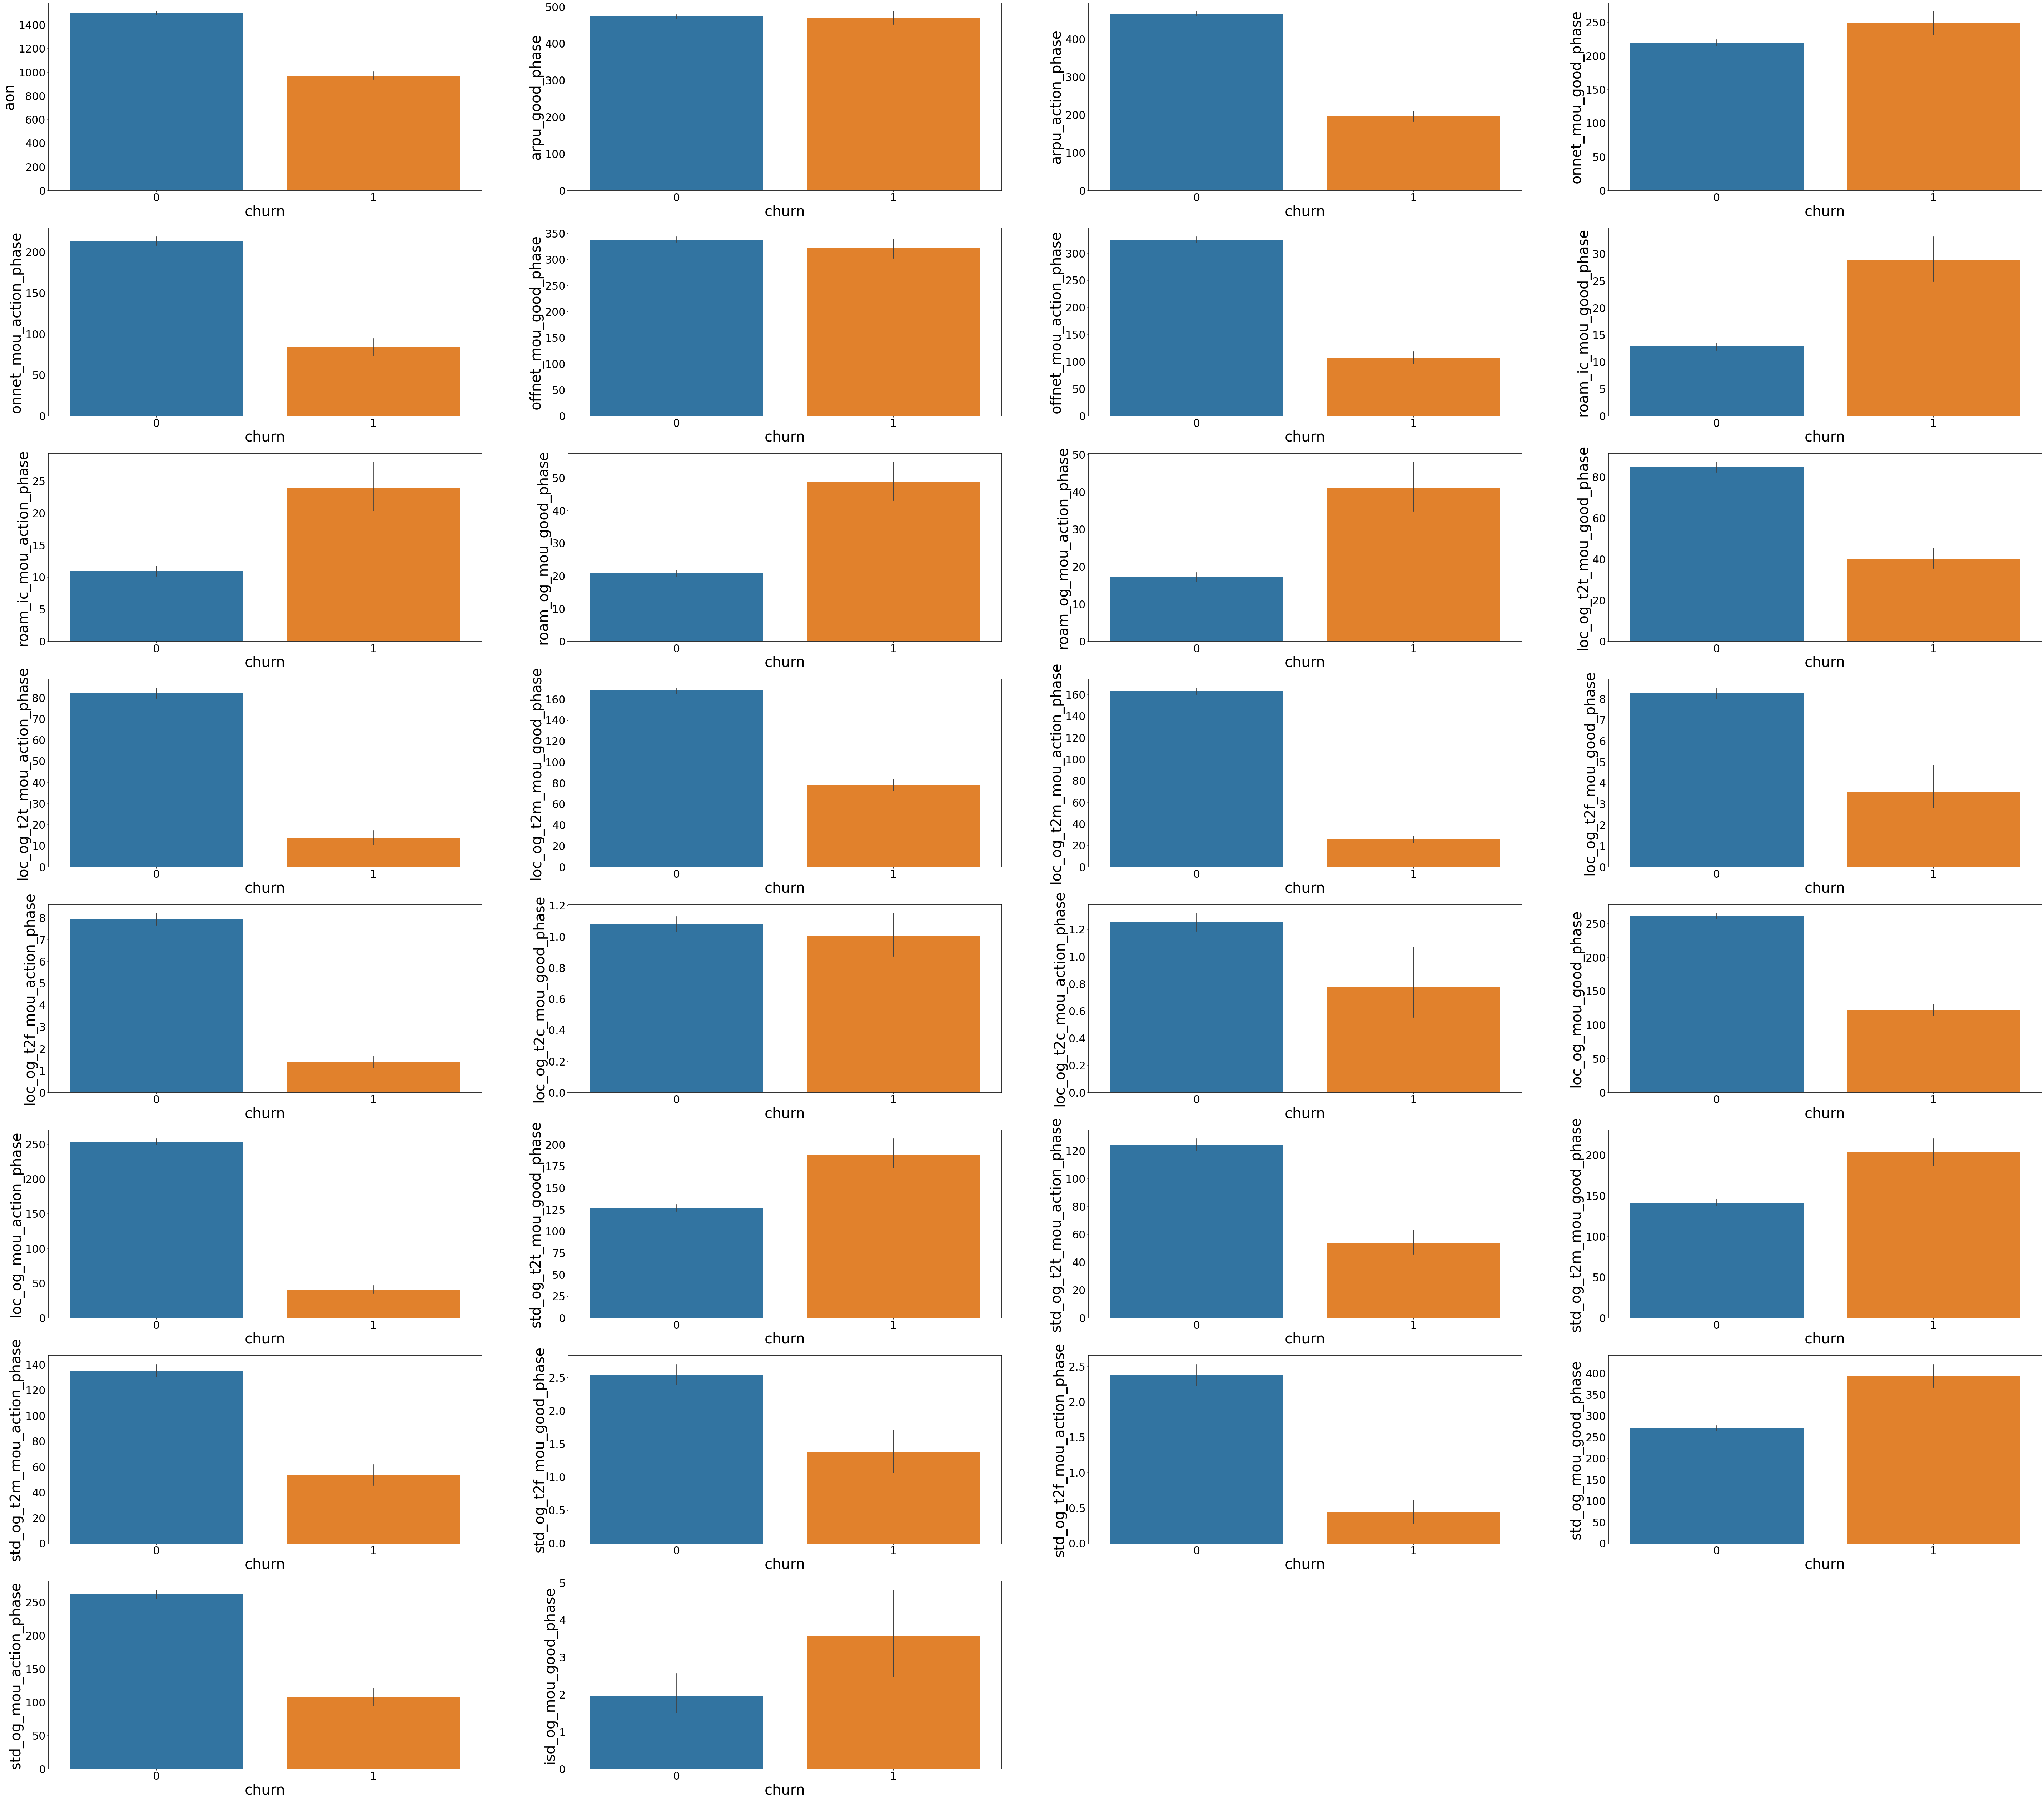

In [72]:
count=1
plt.subplots(figsize=(100,300))
for i in numerical_cols[:30]:
    plt.subplot(26,4,count)
    sns.barplot(HVC_df["churn"],HVC_df[i])
    plt.xlabel('churn', size = 40)
    plt.ylabel(i, size = 40) 
    plt.xticks(size = 30)
    plt.yticks(size = 30)
    count+=1
plt.show()


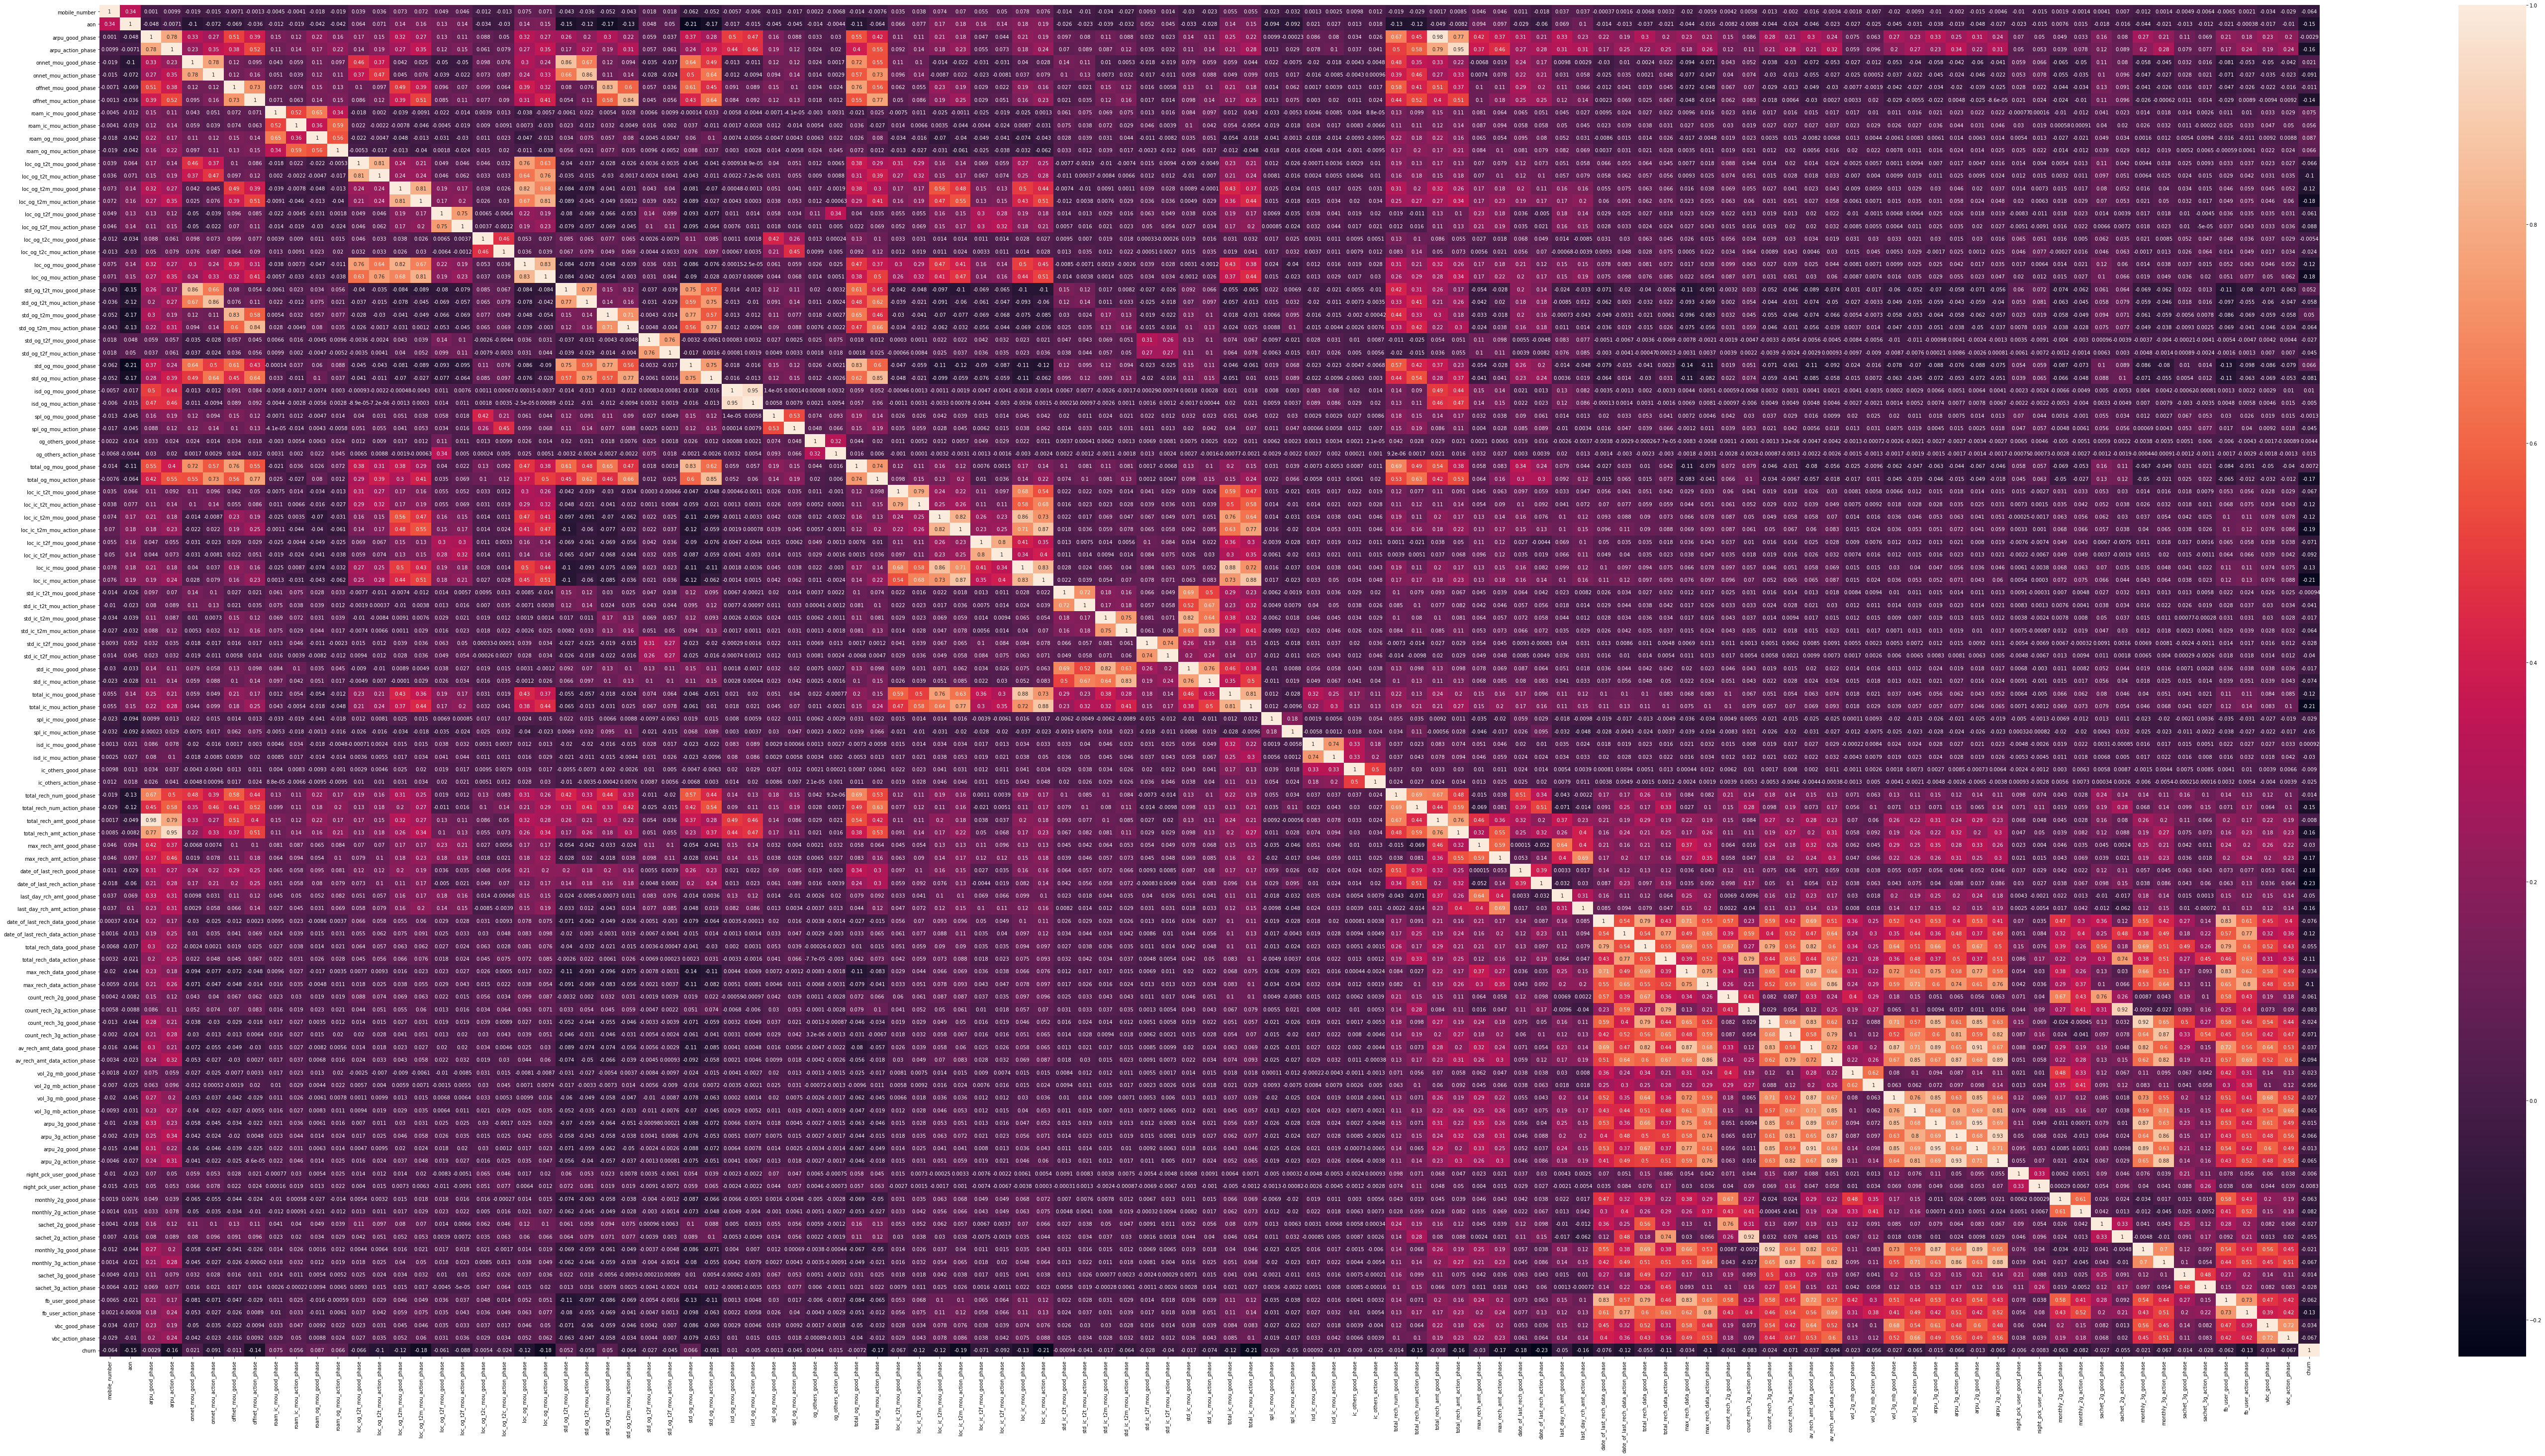

In [73]:
## checking correlation in the data 
%matplotlib inline
plt.figure(figsize = (100,50))
sns.heatmap(HVC_df.corr(),annot = True)
plt.show()

## Model Building

In [74]:
# Putting feature variable to X
X = HVC_df.drop(['mobile_number','churn'],axis=1)

# Putting response variable to y
y = HVC_df['churn']

### Train Test Split

In [75]:
from sklearn.model_selection import train_test_split
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

### Scaling

In [76]:
## scaling the  non-dummy variables with min-max scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train[numerical_cols]=scaler.fit_transform(X_train[numerical_cols])
X_train.head()

aon  arpu_good_phase  arpu_action_phase  onnet_mou_good_phase  \
33510  0.555663         0.125386           0.078909              0.009580   
25392  0.073654         0.121820           0.071465              0.013716   
63251  0.671094         0.112903           0.085063              0.000227   
97628  0.324318         0.264884           0.146792              0.048847   
20699  0.048298         0.106445           0.047022              0.000941   

       onnet_mou_action_phase  offnet_mou_good_phase  offnet_mou_action_phase  \
33510                0.005370               0.017258                 0.019842   
25392                0.016613               0.023992                 0.027351   
63251                0.003658               0.000675                 0.007381   
97628                0.028597               0.113429                 0.075418   
20699                0.000092               0.014434                 0.006028   

       roam_ic_mou_good_phase  roam_ic_mou_action_phase  \
33510                0.000000                  0.000000   
25392                0.001751                  0.000000   
63251                0.000546                  0.014845   
97628                0.056847                  0.000000   
20699                0.005709                  0.000000   

       roam_og_mou_good_phase  roam_og_mou_action_phase  \
33510                0.000000                  0.000000   
25392                0.012280                  0.000000   
63251                0.000000                  0.011373   
97628                0.061784                  0.000000   
20699                0.001576                  0.000000   

       loc_og_t2t_mou_good_phase  loc_og_t2t_mou_action_phase  \
33510                   0.011821                     0.005370   
25392                   0.001270                     0.000799   
63251                   0.000066                     0.001614   
97628                   0.042756                     0.019996   
20699                   0.000486                     0.000092   

       loc_og_t2m_mou_good_phase  loc_og_t2m_mou_action_phase  \
33510                   0.029711                     0.070578   
25392                   0.008412                     0.004530   
63251                   0.001169                     0.011693   
97628                   0.196511                     0.294431   
20699                   0.020802                     0.017910   

       loc_og_t2f_mou_good_phase  loc_og_t2f_mou_action_phase  \
33510                   0.014340                     0.063568   
25392                   0.000454                     0.000000   
63251                   0.000781                     0.019046   
97628                   0.016252                     0.039552   
20699                   0.007290                     0.015869   

       loc_og_t2c_mou_good_phase  loc_og_t2c_mou_action_phase  \
33510                        0.0                     0.000000   
25392                        0.0                     0.000000   
63251                        0.0                     0.037843   
97628                        0.0                     0.000000   
20699                        0.0                     0.015757   

       loc_og_mou_good_phase  loc_og_mou_action_phase  \
33510               0.027488                 0.029716   
25392               0.005178                 0.002150   
63251               0.000766                 0.006047   
97628               0.133911                 0.110553   
20699               0.011656                 0.006292   

       std_og_t2t_mou_good_phase  std_og_t2t_mou_action_phase  \
33510                   0.000000                     0.000000   
25392                   0.012607                     0.025529   
63251                   0.000173                     0.000462   
97628                   0.003855                     0.013402   
20699                   0.000519                     0.000000   

       std_og_t2m_mou_good_phase  std_og_t2m_mou_actio

### Logistic Regression

**Model 1**

In [77]:
import statsmodels.api as sm

logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20962
Model:                            GLM   Df Residuals:                    20862
Model Family:                Binomial   Df Model:                           99
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3736.3
Date:                Sat, 01 May 2021   Deviance:                       7472.7
Time:                        16:26:58   Pearson chi2:                 4.20e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.5382      0.343      1.569      0.117      -0.134       1.210
aon                                    -0.8393      0.159     -5.269      0.000      -1.151      -0.527
arpu_good_phase                         3.9068      2.929      1.334      0.182      -1.835       9.648
arpu_action_phase                       3.7610      2.667      1.410      0.159      -1.467       8.989
onnet_mou_good_phase                    6.6527     44.863      0.148      0.882     -81.277      94.582
onnet_mou_action_phase                  0.0136     60.268      0.000      1.000    -118.109     118.136
offnet_mou_good_phase                   7.9025     41.628      0.190      0.849     -73.688      89.493
offnet_mou_action_phase                -1.4393     77.672     -0.019      0.985    -153.674     150.796
roam_ic_mou_good_phase                  2.9803      0.865      3.445      0.001       1.285       4.676
roam_ic_mou_action_phase               -2.5160      0.941     -2.675      0.007      -4.360      -0.672
roam_og_mou_good_phase                 -0.4938     14.693     -0.034      0.973     -29.292      28.305
roam_og_mou_action_phase               -0.1506     19.541     -0.008      0.994     -38.450      38.149
loc_og_t2t_mou_good_phase            8.927e+04   4.58e+04      1.951      0.051    -411.643    1.79e+05
loc_og_t2t_mou_action_phase          5.399e+05   7.22e+04      7.476      0.000    3.98e+05    6.81e+05
loc_og_t2m_mou_good_phase            4.631e+04   2.37e+04      1.951      0.051    -215.326    9.28e+04
loc_og_t2m_mou_action_phase          1.678e+05   2.24e+04      7.476      0.000    1.24e+05    2.12e+05
loc_og_t2f_mou_good_phase                2e+04   1.03e+04      1.951      0.051     -95.626    4.01e+04
loc_og_t2f_mou_action_phase          2.718e+04   3635.756      7.476      0.000    2.01e+04    3.43e+04
loc_og_t2c_mou_good_phase              -2.5780      1.696     -1.520      0.128      -5.902       0.746
loc_og_t2c_mou_action_phase             4.6111      1.906      2.419      0.016       0.875       8.347
loc_og_mou_good_phase               -1.095e+05   6.74e+04     -1.624      0.104   -2.42e+05    2.27e+04
loc_og_mou_action_phase             -1.548e+05      1e+05     -1.542      0.123   -3.52e+05    4.19e+04
std_og_t2t_mou_good_phase           -3.902e+04   6.93e+04     -0.563      0.574   -1.75e+05    9.69e+04
std_og_t2t_mou_action_phase           4.18e+04   5.94e+04      0.704      0.482   -7.46e+04    1.58e+05
std_og_t2m_mou_good_phase           -3.034e+04   5.39e+04     -0.563      0.574   -1.36e+05    7.53e+04
std_og_t2m_mou_action_phase          8.755e+04   1.24e+05      0.704      0.482   -1.56e+05    3.31e+05
std_og_t2f_mou_good_phase           -1885.8584   3352.889     -0.56

**Model 2 - Using Recursive Feature Elimination**

In [78]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
## taking into account class imbalance
logreg = LogisticRegression(class_weight='balanced')

## running RFE with 25 variables as output
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 25)             
rfe = rfe.fit(X_train, y_train)

In [79]:
## list of all the support variables
col = X_train.columns[rfe.support_]
col

Index(['arpu_good_phase', 'offnet_mou_action_phase', 'roam_ic_mou_good_phase',
       'roam_og_mou_good_phase', 'loc_og_t2m_mou_action_phase',
       'loc_og_t2f_mou_action_phase', 'loc_og_mou_action_phase',
       'std_og_t2f_mou_action_phase', 'std_og_mou_good_phase',
       'std_og_mou_action_phase', 'total_og_mou_action_phase',
       'loc_ic_t2t_mou_action_phase', 'loc_ic_t2m_mou_action_phase',
       'loc_ic_mou_action_phase', 'std_ic_mou_action_phase',
       'total_ic_mou_good_phase', 'total_ic_mou_action_phase',
       'spl_ic_mou_action_phase', 'total_rech_amt_good_phase',
       'total_rech_amt_action_phase', 'last_day_rch_amt_action_phase',
       'total_rech_data_action_phase', 'max_rech_data_good_phase',
       'max_rech_data_action_phase', 'monthly_2g_good_phase'],
      dtype='object')

In [80]:
X_train_sm = sm.add_constant(X_train[col])
model2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = model2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20962
Model:                            GLM   Df Residuals:                    20936
Model Family:                Binomial   Df Model:                           25
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4266.9
Date:                Sat, 01 May 2021   Deviance:                       8533.9
Time:                        16:27:43   Pearson chi2:                 7.73e+12
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -2.0238      0.265     -7.632      0.000      -2.544      -1.504
arpu_good_phase                  12.7454      2.682      4.752      0.000       7.489      18.002
offnet_mou_action_phase          -1.4789      2.736     -0.541      0.589      -6.841       3.883
roam_ic_mou_good_phase            1.7340      0.695      2.496      0.013       0.372       3.096
roam_og_mou_good_phase            3.5871      0.816      4.396      0.000       1.988       5.187
loc_og_t2m_mou_action_phase      -5.0786      2.773     -1.831      0.067     -10.514       0.357
loc_og_t2f_mou_action_phase      -4.2071      2.360     -1.783      0.075      -8.833       0.419
loc_og_mou_action_phase         -16.7071     14.856     -1.125      0.261     -45.825      12.411
std_og_t2f_mou_action_phase      -9.0517      3.860     -2.345      0.019     -16.618      -1.485
std_og_mou_good_phase             2.0192      0.617      3.274      0.001       0.810       3.228
std_og_mou_action_phase         -17.4377     17.665     -0.987      0.324     -52.060      17.185
total_og_mou_action_phase         4.7335     17.800      0.266      0.790     -30.154      39.621
loc_ic_t2t_mou_action_phase       2.5353     17.712      0.143      0.886     -32.179      37.250
loc_ic_t2m_mou_action_phase      -8.5652     10.103     -0.848      0.397     -28.367      11.237
loc_ic_mou_action_phase         -48.0171     16.770     -2.863      0.004     -80.886     -15.149
std_ic_mou_action_phase         -24.0822      5.497     -4.381      0.000     -34.856     -13.308
total_ic_mou_good_phase          10.6800      1.291      8.274      0.000       8.150      13.210
total_ic_mou_action_phase        -7.0076      2.864     -2.447      0.014     -12.621      -1.394
spl_ic_mou_action_phase         -21.6890      3.623     -5.986      0.000     -28.791     -14.587
total_rech_amt_good_phase        -3.8222      2.153     -1.775      0.076      -8.042       0.398
total_rech_amt_action_phase      -5.4892      1.454     -3.775      0.000      -8.339      -2.639
last_day_rch_amt_action_phase   -22.6815      1.985    -11.427      0.000     -26.572     -18.791
total_rech_data_action_phase     -5.4112      1.189     -4.550      0.000      -7.742      -3.080
max_rech_data_good_phase          2.6009      0.686      3.791      0.000       1.256       3.946
max_rech_data_action_phase       -4.7934      0.970     -4.943      0.000      -6.694      -2.893
monthly_2g_good_phase            -2.9811      0.620     -4.810      0.000      -4.196      -1.766
=================================================================================================
"""

In [81]:
# Dropping total_og_mou_action_phase column for high p value and creating the model again with remaining varibles of RFE

col = col.drop('total_og_mou_action_phase',1)

X_train_sm = sm.add_constant(X_train[col]) 
model3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = model3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20962
Model:                            GLM   Df Residuals:                    20937
Model Family:                Binomial   Df Model:                           24
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4267.0
Date:                Sat, 01 May 2021   Deviance:                       8533.9
Time:                        16:27:43   Pearson chi2:                 7.52e+12
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -2.0252      0.265     -7.640      0.000      -2.545      -1.506
arpu_good_phase                  12.7565      2.681      4.757      0.000       7.501      18.012
offnet_mou_action_phase          -1.4303      2.729     -0.524      0.600      -6.780       3.919
roam_ic_mou_good_phase            1.7292      0.695      2.489      0.013       0.368       3.091
roam_og_mou_good_phase            3.5566      0.808      4.402      0.000       1.973       5.140
loc_og_t2m_mou_action_phase      -5.1107      2.771     -1.844      0.065     -10.542       0.321
loc_og_t2f_mou_action_phase      -4.2040      2.359     -1.782      0.075      -8.827       0.419
loc_og_mou_action_phase         -13.0098      5.247     -2.479      0.013     -23.294      -2.726
std_og_t2f_mou_action_phase      -9.0337      3.857     -2.342      0.019     -16.594      -1.473
std_og_mou_good_phase             2.0054      0.614      3.264      0.001       0.801       3.210
std_og_mou_action_phase         -12.7709      2.097     -6.089      0.000     -16.882      -8.660
loc_ic_t2t_mou_action_phase       2.5657     17.711      0.145      0.885     -32.147      37.279
loc_ic_t2m_mou_action_phase      -8.5565     10.104     -0.847      0.397     -28.359      11.246
loc_ic_mou_action_phase         -48.0610     16.768     -2.866      0.004     -80.926     -15.196
std_ic_mou_action_phase         -24.1246      5.490     -4.394      0.000     -34.885     -13.364
total_ic_mou_good_phase          10.6781      1.285      8.311      0.000       8.160      13.196
total_ic_mou_action_phase        -6.9790      2.852     -2.447      0.014     -12.569      -1.389
spl_ic_mou_action_phase         -21.6840      3.623     -5.984      0.000     -28.786     -14.582
total_rech_amt_good_phase        -3.7988      2.151     -1.766      0.077      -8.016       0.418
total_rech_amt_action_phase      -5.4092      1.424     -3.800      0.000      -8.200      -2.619
last_day_rch_amt_action_phase   -22.6982      1.984    -11.439      0.000     -26.587     -18.809
total_rech_data_action_phase     -5.4213      1.189     -4.559      0.000      -7.752      -3.091
max_rech_data_good_phase          2.5905      0.685      3.782      0.000       1.248       3.933
max_rech_data_action_phase       -4.8013      0.969     -4.952      0.000      -6.701      -2.901
monthly_2g_good_phase            -2.9794      0.620     -4.809      0.000      -4.194      -1.765
=================================================================================================
"""

In [82]:
# Dropping loc_ic_t2t_mou_action_phase column for high p value and creating the model again with remaining varibles of RFE

col = col.drop('loc_ic_t2t_mou_action_phase',1)

X_train_sm = sm.add_constant(X_train[col]) 
model4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = model4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20962
Model:                            GLM   Df Residuals:                    20938
Model Family:                Binomial   Df Model:                           23
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4267.0
Date:                Sat, 01 May 2021   Deviance:                       8534.0
Time:                        16:27:43   Pearson chi2:                 7.59e+12
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -2.0245      0.265     -7.639      0.000      -2.544      -1.505
arpu_good_phase                  12.7485      2.681      4.756      0.000       7.495      18.002
offnet_mou_action_phase          -1.4331      2.729     -0.525      0.599      -6.782       3.916
roam_ic_mou_good_phase            1.7285      0.695      2.487      0.013       0.367       3.090
roam_og_mou_good_phase            3.5580      0.808      4.403      0.000       1.974       5.142
loc_og_t2m_mou_action_phase      -5.1307      2.763     -1.857      0.063     -10.545       0.284
loc_og_t2f_mou_action_phase      -4.2715      2.316     -1.845      0.065      -8.810       0.267
loc_og_mou_action_phase         -12.9209      5.191     -2.489      0.013     -23.095      -2.747
std_og_t2f_mou_action_phase      -9.0400      3.858     -2.343      0.019     -16.602      -1.477
std_og_mou_good_phase             2.0043      0.614      3.262      0.001       0.800       3.208
std_og_mou_action_phase         -12.7618      2.096     -6.088      0.000     -16.870      -8.653
loc_ic_t2m_mou_action_phase      -9.7955      5.335     -1.836      0.066     -20.252       0.661
loc_ic_mou_action_phase         -45.8686      7.125     -6.437      0.000     -59.834     -31.903
std_ic_mou_action_phase         -24.1344      5.490     -4.396      0.000     -34.894     -13.375
total_ic_mou_good_phase          10.6823      1.284      8.316      0.000       8.165      13.200
total_ic_mou_action_phase        -6.9826      2.852     -2.448      0.014     -12.573      -1.392
spl_ic_mou_action_phase         -21.6811      3.623     -5.983      0.000     -28.783     -14.579
total_rech_amt_good_phase        -3.7894      2.150     -1.762      0.078      -8.004       0.425
total_rech_amt_action_phase      -5.4057      1.424     -3.797      0.000      -8.196      -2.616
last_day_rch_amt_action_phase   -22.6996      1.984    -11.440      0.000     -26.589     -18.811
total_rech_data_action_phase     -5.4207      1.189     -4.559      0.000      -7.751      -3.090
max_rech_data_good_phase          2.5901      0.685      3.782      0.000       1.248       3.932
max_rech_data_action_phase       -4.8030      0.969     -4.954      0.000      -6.703      -2.903
monthly_2g_good_phase            -2.9805      0.620     -4.811      0.000      -4.195      -1.766
=================================================================================================
"""

In [83]:
# Dropping loc_ic_t2m_mou_action_phase column for high p value and creating the model again with remaining varibles of RFE

col = col.drop('loc_ic_t2m_mou_action_phase',1)

X_train_sm = sm.add_constant(X_train[col]) 
model5 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = model5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20962
Model:                            GLM   Df Residuals:                    20939
Model Family:                Binomial   Df Model:                           22
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4268.6
Date:                Sat, 01 May 2021   Deviance:                       8537.3
Time:                        16:27:43   Pearson chi2:                 8.23e+12
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -2.0202      0.265     -7.626      0.000      -2.539      -1.501
arpu_good_phase                  12.6980      2.680      4.738      0.000       7.445      17.951
offnet_mou_action_phase          -1.5016      2.728     -0.551      0.582      -6.848       3.844
roam_ic_mou_good_phase            1.7362      0.697      2.492      0.013       0.371       3.102
roam_og_mou_good_phase            3.5309      0.807      4.374      0.000       1.949       5.113
loc_og_t2m_mou_action_phase      -6.6203      2.576     -2.570      0.010     -11.669      -1.572
loc_og_t2f_mou_action_phase      -4.0903      2.302     -1.777      0.076      -8.602       0.421
loc_og_mou_action_phase         -11.0156      4.695     -2.346      0.019     -20.217      -1.814
std_og_t2f_mou_action_phase      -9.0298      3.859     -2.340      0.019     -16.594      -1.465
std_og_mou_good_phase             2.0061      0.614      3.270      0.001       0.804       3.209
std_og_mou_action_phase         -12.7708      2.095     -6.095      0.000     -16.877      -8.664
loc_ic_mou_action_phase         -56.6171      4.293    -13.187      0.000     -65.032     -48.202
std_ic_mou_action_phase         -24.0370      5.486     -4.382      0.000     -34.789     -13.285
total_ic_mou_good_phase          10.6970      1.272      8.408      0.000       8.203      13.190
total_ic_mou_action_phase        -7.0216      2.847     -2.466      0.014     -12.602      -1.441
spl_ic_mou_action_phase         -21.7808      3.627     -6.005      0.000     -28.889     -14.672
total_rech_amt_good_phase        -3.7633      2.152     -1.749      0.080      -7.981       0.455
total_rech_amt_action_phase      -5.3238      1.421     -3.747      0.000      -8.109      -2.539
last_day_rch_amt_action_phase   -22.6694      1.984    -11.427      0.000     -26.558     -18.781
total_rech_data_action_phase     -5.4131      1.189     -4.553      0.000      -7.743      -3.083
max_rech_data_good_phase          2.5747      0.684      3.763      0.000       1.234       3.916
max_rech_data_action_phase       -4.8145      0.969     -4.967      0.000      -6.714      -2.915
monthly_2g_good_phase            -2.9806      0.619     -4.812      0.000      -4.195      -1.767
=================================================================================================
"""

In [84]:
# Dropping loc_og_t2f_mou_action_phase column for high p value and creating the model again with remaining varibles of RFE

col = col.drop('loc_og_t2f_mou_action_phase',1)

X_train_sm = sm.add_constant(X_train[col]) 
model6 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = model6.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20962
Model:                            GLM   Df Residuals:                    20940
Model Family:                Binomial   Df Model:                           21
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4270.5
Date:                Sat, 01 May 2021   Deviance:                       8540.9
Time:                        16:27:44   Pearson chi2:                 8.28e+12
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -2.0338      0.264     -7.692      0.000      -2.552      -1.516
arpu_good_phase                  12.7866      2.675      4.779      0.000       7.543      18.030
offnet_mou_action_phase          -1.8120      2.720     -0.666      0.505      -7.144       3.520
roam_ic_mou_good_phase            1.7303      0.695      2.488      0.013       0.367       3.093
roam_og_mou_good_phase            3.6345      0.806      4.510      0.000       2.055       5.214
loc_og_t2m_mou_action_phase      -6.5592      2.645     -2.479      0.013     -11.744      -1.374
loc_og_mou_action_phase         -12.0010      4.943     -2.428      0.015     -21.688      -2.314
std_og_t2f_mou_action_phase      -9.7362      3.917     -2.485      0.013     -17.414      -2.058
std_og_mou_good_phase             2.0747      0.612      3.388      0.001       0.874       3.275
std_og_mou_action_phase         -12.5207      2.085     -6.006      0.000     -16.607      -8.435
loc_ic_mou_action_phase         -57.1360      4.329    -13.200      0.000     -65.620     -48.652
std_ic_mou_action_phase         -24.0928      5.496     -4.384      0.000     -34.865     -13.321
total_ic_mou_good_phase          10.7384      1.280      8.391      0.000       8.230      13.247
total_ic_mou_action_phase        -7.1968      2.887     -2.493      0.013     -12.855      -1.539
spl_ic_mou_action_phase         -21.6741      3.625     -5.980      0.000     -28.778     -14.570
total_rech_amt_good_phase        -3.8983      2.145     -1.818      0.069      -8.102       0.305
total_rech_amt_action_phase      -5.3590      1.422     -3.767      0.000      -8.147      -2.571
last_day_rch_amt_action_phase   -22.7741      1.980    -11.501      0.000     -26.655     -18.893
total_rech_data_action_phase     -5.3643      1.187     -4.518      0.000      -7.691      -3.037
max_rech_data_good_phase          2.6112      0.684      3.817      0.000       1.270       3.952
max_rech_data_action_phase       -4.8332      0.969     -4.988      0.000      -6.732      -2.934
monthly_2g_good_phase            -2.9750      0.619     -4.803      0.000      -4.189      -1.761
=================================================================================================
"""

In [85]:
# Dropping offnet_mou_action_phase column for high p value and creating the model again with remaining varibles of RFE

col = col.drop('offnet_mou_action_phase',1)

X_train_sm = sm.add_constant(X_train[col]) 
model7 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = model7.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20962
Model:                            GLM   Df Residuals:                    20941
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4270.7
Date:                Sat, 01 May 2021   Deviance:                       8541.4
Time:                        16:27:44   Pearson chi2:                 9.39e+12
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -2.0427      0.264     -7.733      0.000      -2.560      -1.525
arpu_good_phase                  12.8813      2.672      4.821      0.000       7.644      18.118
roam_ic_mou_good_phase            1.7161      0.694      2.473      0.013       0.356       3.076
roam_og_mou_good_phase            3.5618      0.798      4.461      0.000       1.997       5.127
loc_og_t2m_mou_action_phase      -7.0336      2.549     -2.760      0.006     -12.029      -2.039
loc_og_mou_action_phase         -11.9375      4.941     -2.416      0.016     -21.621      -2.254
std_og_t2f_mou_action_phase      -9.8168      3.921     -2.503      0.012     -17.502      -2.131
std_og_mou_good_phase             2.0333      0.609      3.338      0.001       0.839       3.227
std_og_mou_action_phase         -13.1502      1.878     -7.001      0.000     -16.832      -9.469
loc_ic_mou_action_phase         -57.0812      4.330    -13.183      0.000     -65.568     -48.595
std_ic_mou_action_phase         -24.2601      5.494     -4.416      0.000     -35.029     -13.492
total_ic_mou_good_phase          10.6942      1.278      8.371      0.000       8.190      13.198
total_ic_mou_action_phase        -7.1367      2.887     -2.472      0.013     -12.795      -1.478
spl_ic_mou_action_phase         -21.7379      3.625     -5.997      0.000     -28.842     -14.633
total_rech_amt_good_phase        -3.9380      2.143     -1.837      0.066      -8.139       0.263
total_rech_amt_action_phase      -5.5762      1.387     -4.020      0.000      -8.295      -2.858
last_day_rch_amt_action_phase   -22.7217      1.979    -11.482      0.000     -26.600     -18.843
total_rech_data_action_phase     -5.3686      1.188     -4.520      0.000      -7.697      -3.040
max_rech_data_good_phase          2.6016      0.684      3.804      0.000       1.261       3.942
max_rech_data_action_phase       -4.8039      0.968     -4.965      0.000      -6.700      -2.908
monthly_2g_good_phase            -2.9776      0.619     -4.807      0.000      -4.192      -1.764
=================================================================================================
"""

In [86]:
# Dropping total_rech_amt_good_phase column for high p value and creating the model again with remaining varibles of RFE

col = col.drop('total_rech_amt_good_phase',1)

X_train_sm = sm.add_constant(X_train[col]) 
model8 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = model8.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20962
Model:                            GLM   Df Residuals:                    20942
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4272.4
Date:                Sat, 01 May 2021   Deviance:                       8544.8
Time:                        16:27:44   Pearson chi2:                 9.46e+12
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -1.6181      0.130    -12.489      0.000      -1.872      -1.364
arpu_good_phase                   8.3886      1.095      7.660      0.000       6.242      10.535
roam_ic_mou_good_phase            1.7350      0.692      2.509      0.012       0.380       3.090
roam_og_mou_good_phase            3.4025      0.792      4.297      0.000       1.851       4.954
loc_og_t2m_mou_action_phase      -7.1225      2.561     -2.782      0.005     -12.141      -2.104
loc_og_mou_action_phase         -12.1656      4.990     -2.438      0.015     -21.945      -2.386
std_og_t2f_mou_action_phase      -9.8049      3.924     -2.499      0.012     -17.496      -2.114
std_og_mou_good_phase             1.9574      0.609      3.212      0.001       0.763       3.152
std_og_mou_action_phase         -13.2537      1.876     -7.063      0.000     -16.932      -9.576
loc_ic_mou_action_phase         -57.0967      4.343    -13.148      0.000     -65.608     -48.586
std_ic_mou_action_phase         -24.1326      5.511     -4.379      0.000     -34.934     -13.331
total_ic_mou_good_phase          10.6742      1.278      8.353      0.000       8.170      13.179
total_ic_mou_action_phase        -7.1829      2.903     -2.475      0.013     -12.872      -1.494
spl_ic_mou_action_phase         -21.7107      3.624     -5.990      0.000     -28.814     -14.607
total_rech_amt_action_phase      -5.5449      1.385     -4.003      0.000      -8.260      -2.830
last_day_rch_amt_action_phase   -22.5537      1.976    -11.413      0.000     -26.427     -18.681
total_rech_data_action_phase     -5.4060      1.190     -4.542      0.000      -7.739      -3.073
max_rech_data_good_phase          2.5709      0.685      3.754      0.000       1.229       3.913
max_rech_data_action_phase       -4.8043      0.969     -4.957      0.000      -6.704      -2.905
monthly_2g_good_phase            -2.9747      0.619     -4.802      0.000      -4.189      -1.761
=================================================================================================
"""

**Checking the VIF**

In [87]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [88]:
vif = pd.DataFrame()
X = X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                           const  20.51
12      total_ic_mou_action_phase  19.11
9         loc_ic_mou_action_phase  13.14
10        std_ic_mou_action_phase   4.05
14    total_rech_amt_action_phase   3.75
7           std_og_mou_good_phase   3.39
1                 arpu_good_phase   3.35
8         std_og_mou_action_phase   3.29
4     loc_og_t2m_mou_action_phase   3.12
5         loc_og_mou_action_phase   3.12
11        total_ic_mou_good_phase   3.12
18     max_rech_data_action_phase   2.96
17       max_rech_data_good_phase   2.80
3          roam_og_mou_good_phase   1.94
2          roam_ic_mou_good_phase   1.79
16   total_rech_data_action_phase   1.49
15  last_day_rch_amt_action_phase   1.30
19          monthly_2g_good_phase   1.19
6     std_og_t2f_mou_action_phase   1.02
13        spl_ic_mou_action_phase   1.02

In [89]:
## dropping the variable "total_ic_mou_action_phase" for high VIF and creating the model again with remaining varibles of RFE

col = col.drop('total_ic_mou_action_phase',1)

X_train_sm = sm.add_constant(X_train[col]) 
model9 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = model9.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                20962
Model:                            GLM   Df Residuals:                    20943
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4276.6
Date:                Sat, 01 May 2021   Deviance:                       8553.2
Time:                        16:27:45   Pearson chi2:                 1.18e+13
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -1.6314      0.130    -12.566      0.000      -1.886      -1.377
arpu_good_phase                   8.6194      1.095      7.874      0.000       6.474      10.765
roam_ic_mou_good_phase            1.7877      0.688      2.597      0.009       0.439       3.137
roam_og_mou_good_phase            3.3534      0.789      4.248      0.000       1.806       4.901
loc_og_t2m_mou_action_phase      -7.1648      2.572     -2.786      0.005     -12.205      -2.124
loc_og_mou_action_phase         -12.1803      5.042     -2.416      0.016     -22.063      -2.297
std_og_t2f_mou_action_phase      -9.6799      3.917     -2.471      0.013     -17.357      -2.003
std_og_mou_good_phase             2.0144      0.610      3.302      0.001       0.819       3.210
std_og_mou_action_phase         -13.3335      1.875     -7.110      0.000     -17.009      -9.658
loc_ic_mou_action_phase         -63.0169      3.490    -18.057      0.000     -69.857     -56.177
std_ic_mou_action_phase         -32.0599      4.759     -6.736      0.000     -41.388     -22.732
total_ic_mou_good_phase           9.0297      1.107      8.160      0.000       6.861      11.198
spl_ic_mou_action_phase         -21.8260      3.627     -6.018      0.000     -28.935     -14.717
total_rech_amt_action_phase      -5.7618      1.374     -4.194      0.000      -8.454      -3.069
last_day_rch_amt_action_phase   -22.5480      1.973    -11.428      0.000     -26.415     -18.681
total_rech_data_action_phase     -5.3482      1.183     -4.522      0.000      -7.666      -3.030
max_rech_data_good_phase          2.5383      0.685      3.707      0.000       1.196       3.880
max_rech_data_action_phase       -4.8608      0.963     -5.047      0.000      -6.749      -2.973
monthly_2g_good_phase            -2.9068      0.616     -4.722      0.000      -4.113      -1.700
=================================================================================================
"""

In [90]:
## checking VIF now
vif = pd.DataFrame()
X = X_train_sm
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features    VIF
0                           const  20.48
13    total_rech_amt_action_phase   3.70
7           std_og_mou_good_phase   3.38
1                 arpu_good_phase   3.34
8         std_og_mou_action_phase   3.29
4     loc_og_t2m_mou_action_phase   3.12
5         loc_og_mou_action_phase   3.12
17     max_rech_data_action_phase   2.96
16       max_rech_data_good_phase   2.80
9         loc_ic_mou_action_phase   2.77
11        total_ic_mou_good_phase   2.74
3          roam_og_mou_good_phase   1.94
2          roam_ic_mou_good_phase   1.79
15   total_rech_data_action_phase   1.49
14  last_day_rch_amt_action_phase   1.30
10        std_ic_mou_action_phase   1.26
18          monthly_2g_good_phase   1.19
12        spl_ic_mou_action_phase   1.02
6     std_og_t2f_mou_action_phase   1.02

In [91]:
## Making predictions now
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

33510    5.953094e-02
25392    9.482341e-02
63251    1.588134e-02
97628    1.964272e-05
20699    2.586452e-02
4793     2.572975e-07
82660    5.305673e-04
74050    1.353426e-01
92154    2.377300e-05
47382    3.941653e-03
dtype: float64

In [92]:
## reshaping the values to get an array
y_train_pred = y_train_pred.values.reshape(-1)

In [93]:
## putting the model provided probability values and the actual values in a dataframe along with row numbers
y_train_pred_df = pd.DataFrame({'churn':y_train.values, 'churn_pred':y_train_pred})
y_train_pred_df['id'] = y_train.index
y_train_pred_df.head()

churn  churn_pred     id
0      0    0.059531  33510
1      0    0.094823  25392
2      0    0.015881  63251
3      0    0.000020  97628
4      0    0.025865  20699

In [94]:
## making prediction with any arbitrary cut-off value
y_train_pred_df['prediction']= y_train_pred_df.churn_pred.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_df.head()

churn  churn_pred     id  prediction
0      0    0.059531  33510           0
1      0    0.094823  25392           0
2      0    0.015881  63251           0
3      0    0.000020  97628           0
4      0    0.025865  20699           0

**Accuracy**

In [95]:
# checking accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_train_pred_df.churn, y_train_pred_df.prediction))

0.9177559393187673


**ROC Curve**

In [96]:
# function to draw the ROC curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(10, 10))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for model')
    plt.legend(loc="lower right")
    plt.show()

    return None

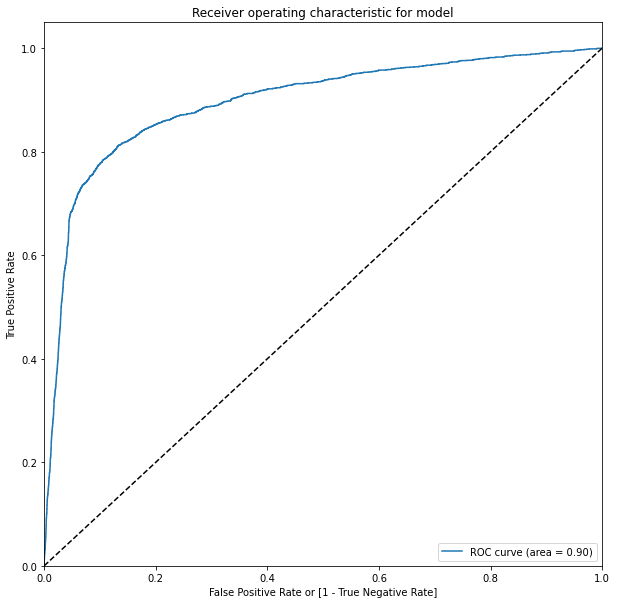

In [97]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_df.churn, y_train_pred_df.prediction, drop_intermediate = False )

## draw ROC curve based on the probability values generated by the model
draw_roc(y_train_pred_df.churn, y_train_pred_df.churn_pred)

**Finding Optimal Cutoff Point**

In [98]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_df[i]= y_train_pred_df.churn_pred.map(lambda x: 1 if x > i else 0)
y_train_pred_df.head()

churn  churn_pred     id  prediction  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
0      0    0.059531  33510           0    1    0    0    0    0    0    0   
1      0    0.094823  25392           0    1    0    0    0    0    0    0   
2      0    0.015881  63251           0    1    0    0    0    0    0    0   
3      0    0.000020  97628           0    1    0    0    0    0    0    0   
4      0    0.025865  20699           0    1    0    0    0    0    0    0   

   0.7  0.8  0.9  
0    0    0    0  
1    0    0    0  
2    0    0    0  
3    0    0    0  
4    0    0    0

In [99]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci','ppv','npv'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_df.churn, y_train_pred_df[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    ppv = cm1[1,1] /(cm1[1,1]+cm1[0,1])
    npv = cm1[0,0]/(cm1[0,0]+cm1[1,0])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci,ppv, npv ]
print(cutoff_df)

     prob  accuracy     sensi     speci       ppv       npv
0.0   0.0  0.090926  1.000000  0.000000  0.090926       NaN
0.1   0.1  0.808511  0.849948  0.804366  0.302917  0.981683
0.2   0.2  0.893522  0.768101  0.906066  0.449908  0.975040
0.3   0.3  0.927058  0.684155  0.951354  0.584491  0.967861
0.4   0.4  0.923528  0.409234  0.974969  0.620525  0.942857
0.5   0.5  0.917756  0.209864  0.988560  0.647249  0.925973
0.6   0.6  0.914941  0.114376  0.995015  0.696486  0.918253
0.7   0.7  0.911840  0.059286  0.997114  0.672619  0.913773
0.8   0.8  0.910457  0.025708  0.998950  0.710145  0.911119
0.9   0.9  0.910028  0.012592  0.999790  0.857143  0.910098


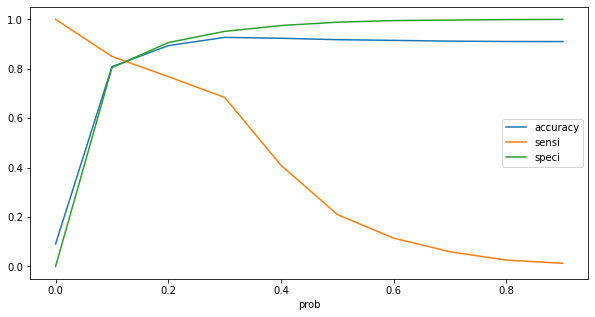

In [100]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'],figsize=(10, 5))
plt.show()

**From the above graph we see that the optimal cut 0ff is at 0.17**

In [101]:
# making our final prediction on basis of optimal cut-off of 0.17
y_train_pred_df['final_predicted'] = y_train_pred_df.churn_pred.map( lambda x: 1 if x > 0.17 else 0)
y_train_pred_df.head()

churn  churn_pred     id  prediction  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
0      0    0.059531  33510           0    1    0    0    0    0    0    0   
1      0    0.094823  25392           0    1    0    0    0    0    0    0   
2      0    0.015881  63251           0    1    0    0    0    0    0    0   
3      0    0.000020  97628           0    1    0    0    0    0    0    0   
4      0    0.025865  20699           0    1    0    0    0    0    0    0   

   0.7  0.8  0.9  final_predicted  
0    0    0    0                0  
1    0    0    0                0  
2    0    0    0                0  
3    0    0    0                0  
4    0    0    0                0

**Confusion Matrix**

In [102]:
# creating confusion matrix
confusion_matrix = metrics.confusion_matrix(y_train_pred_df.churn, y_train_pred_df.final_predicted )
confusion_matrix

array([[16858,  2198],
       [  396,  1510]], dtype=int64)

In [103]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_df.churn, y_train_pred_df.final_predicted)

0.8762522660051522

**Precision and Recall**

In [104]:
from sklearn.metrics import precision_score, recall_score
## using precision_score to evaluate matrics
print("precision : ", precision_score(y_train_pred_df.churn, y_train_pred_df.final_predicted))
## using recall_score to evaluate matrics
print("recall : ", recall_score(y_train_pred_df.churn, y_train_pred_df.final_predicted))

precision :  0.40722761596548
recall :  0.7922350472193075


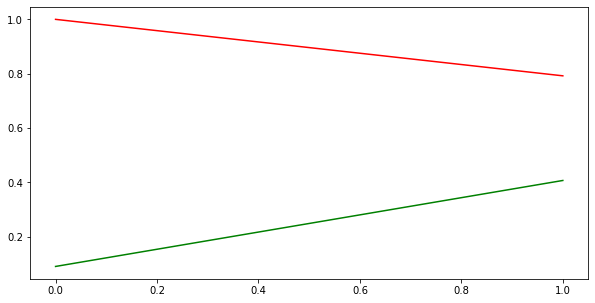

In [105]:
## using precision_recall_curve from matrics
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_train_pred_df.churn, y_train_pred_df.final_predicted)

plt.figure(figsize=(10, 5))
plt.plot(thresholds, p[:-1], "g-", label ="precision")
plt.plot(thresholds, r[:-1], "r-", label ="recall")
plt.show()

**Prediction on test data**

In [106]:
#transforming test data
X_test[numerical_cols]=scaler.transform(X_test[numerical_cols])
X_test.head()

aon  arpu_good_phase  arpu_action_phase  onnet_mou_good_phase  \
60217  0.037431         0.142750           0.041121              0.081228   
26722  0.067134         0.114882           0.055677              0.000000   
82411  0.293407         0.191167           0.141431              0.004461   
16868  0.662400         0.219653           0.144627              0.003787   
38631  0.076793         0.182540           0.115643              0.142554   

       onnet_mou_action_phase  offnet_mou_good_phase  offnet_mou_action_phase  \
60217                0.000024               0.040217                 0.000035   
26722                0.000000               0.000000                 0.000000   
82411                0.000221               0.021625                 0.013183   
16868                0.001216               0.011439                 0.003857   
38631                0.066162               0.111347                 0.046311   

       roam_ic_mou_good_phase  roam_ic_mou_action_phase  \
60217                0.000232                  0.016052   
26722                0.000000                  0.000000   
82411                0.000000                  0.000000   
16868                0.000000                  0.000000   
38631                0.000000                  0.000000   

       roam_og_mou_good_phase  roam_og_mou_action_phase  \
60217                0.005048                  0.000218   
26722                0.000000                  0.000000   
82411                0.000000                  0.000000   
16868                0.000000                  0.000000   
38631                0.000000                  0.000000   

       loc_og_t2t_mou_good_phase  loc_og_t2t_mou_action_phase  \
60217                   0.000936                     0.000000   
26722                   0.000000                     0.000000   
82411                   0.004878                     0.000221   
16868                   0.004605                     0.001216   
38631                   0.025133                     0.014518   

       loc_og_t2m_mou_good_phase  loc_og_t2m_mou_action_phase  \
60217                   0.013717                     0.000000   
26722                   0.000000                     0.000000   
82411                   0.007364                     0.000509   
16868                   0.017500                     0.014071   
38631                   0.033762                     0.026138   

       loc_og_t2f_mou_good_phase  loc_og_t2f_mou_action_phase  \
60217                   0.000000                     0.000000   
26722                   0.000000                     0.000000   
82411                   0.000000                     0.000000   
16868                   0.018179                     0.012913   
38631                   0.000000                     0.000000   

       loc_og_t2c_mou_good_phase  loc_og_t2c_mou_action_phase  \
60217                   0.007999                     0.000000   
26722                   0.000000                     0.000000   
82411                   0.000000                     0.004483   
16868                   0.000000                     0.000000   
38631                   0.000000                     0.000000   

       loc_og_mou_good_phase  loc_og_mou_action_phase  \
60217               0.007270                 0.000000   
26722               0.000000                 0.000000   
82411               0.007852                 0.000370   
16868               0.016031                 0.006079   
38631               0.038498                 0.022055   

       std_og_t2t_mou_good_phase  std_og_t2t_mou_action_phase  \
60217                   0.079366                     0.000000   
26722                   0.000000                     0.000000   
82411                   0.000510                     0.000000   
16868                   0.000055                     0.000000   
38631                   0.122568                     0.083374   

       std_og_t2m_mou_good_phase  std_og_t2m_mou_actio

In [107]:
# adding constant to the test dataset
X_test_sm = sm.add_constant(X_test[col])

In [108]:
# making prediction probabilities
y_test_pred = res.predict(X_test_sm)
## checking values
y_test_pred[:10]

60217    0.433748
26722    0.242458
82411    0.018727
16868    0.016403
38631    0.004317
26358    0.049759
35078    0.010021
57150    0.259572
75575    0.013210
10484    0.267809
dtype: float64

In [109]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

# Let's see the head
y_pred_1.head()

0
60217  0.433748
26722  0.242458
82411  0.018727
16868  0.016403
38631  0.004317

In [110]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

y_test_df['id'] = y_test_df.index

In [111]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_df = pd.concat([y_test_df, y_pred_1],axis=1)
y_pred_df.head()

churn     id         0
0      0  60217  0.433748
1      0  26722  0.242458
2      0  82411  0.018727
3      0  16868  0.016403
4      0  38631  0.004317

In [112]:
# Renaming the column 
y_pred_df= y_pred_df.rename(columns={ 0 : 'churn_pred'})

# Rearranging the columns
y_pred_df = y_pred_df.reindex(['id','churn','churn_pred'], axis=1)

# Let's see the head of y_pred_df
y_pred_df.head()

id  churn  churn_pred
0  60217      0    0.433748
1  26722      0    0.242458
2  82411      0    0.018727
3  16868      0    0.016403
4  38631      0    0.004317

In [113]:
# evaluating result based on the cut-off value obtained above
y_pred_df['final_predicted'] = y_pred_df.churn_pred.map(lambda x: 1 if x > 0.17 else 0)
y_pred_df.head()

id  churn  churn_pred  final_predicted
0  60217      0    0.433748                1
1  26722      0    0.242458                1
2  82411      0    0.018727                0
3  16868      0    0.016403                0
4  38631      0    0.004317                0

In [114]:
# creating confusion matrix for test data
confusion2 = metrics.confusion_matrix(y_pred_df.churn, y_pred_df.final_predicted )
confusion2

array([[7249,  979],
       [ 141,  615]], dtype=int64)

In [115]:
## checking for  accuracy, precision and recall
print("accuracy : ", metrics.accuracy_score(y_pred_df.churn, y_pred_df.final_predicted))
print("precision : ", metrics.precision_score(y_pred_df.churn, y_pred_df.final_predicted))
print("recall : ", metrics.recall_score(y_pred_df.churn, y_pred_df.final_predicted))

accuracy :  0.8753339269813001
precision :  0.3858218318695107
recall :  0.8134920634920635


#### The Logistic Regression model provided an Accuracy of 87%

## Logistic Regression Model using Regularization (L1 / L2)

In [116]:
# Grid search cross validation
from sklearn.linear_model import LogisticRegression

# grid search CV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV


# set up cross validation scheme
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
params = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}# l1 lasso l2 ridge

## using Logistic regression for class imbalance
model = LogisticRegression(class_weight='balanced')
model_cv = GridSearchCV(estimator = model, param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        return_train_score=True, verbose = 1)            
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   18.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='recall', verbose=1)

In [117]:
# Checking the results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.009582      0.003178         0.000000        0.000000   0.001   
1        0.100796      0.006402         0.003199        0.003918   0.001   
2        0.011203      0.003917         0.000000        0.000000    0.01   
3        0.152012      0.007153         0.003196        0.003914    0.01   
4        0.012795      0.003923         0.000000        0.000000     0.1   
5        0.315208      0.042214         0.004799        0.003918     0.1   
6        0.012801      0.003919         0.000000        0.000000       1   
7        0.715205      0.051745         0.006398        0.003199       1   
8        0.011203      0.003917         0.000000        0.000000      10   
9        0.732809      0.048158         0.009588        0.003183      10   
10       0.011213      0.003923         0.000000        0.000000     100   
11       0.696256      0.027148         0.004797        0.003917     100   
12       0.011200      0.003919         0.000000        0.000000    1000   
13       0.678151      0.014866         0.004791        0.003912    1000   

   param_penalty                          params  split0_test_score  \
0             l1   {'C': 0.001, 'penalty': 'l1'}                NaN   
1             l2   {'C': 0.001, 'penalty': 'l2'}           0.729659   
2             l1    {'C': 0.01, 'penalty': 'l1'}                NaN   
3             l2    {'C': 0.01, 'penalty': 'l2'}           0.758530   
4             l1     {'C': 0.1, 'penalty': 'l1'}                NaN   
5             l2     {'C': 0.1, 'penalty': 'l2'}           0.821522   
6             l1     {'C': 1.0, 'penalty': 'l1'}                NaN   
7             l2     {'C': 1.0, 'penalty': 'l2'}           0.847769   
8             l1    {'C': 10.0, 'penalty': 'l1'}                NaN   
9             l2    {'C': 10.0, 'penalty': 'l2'}           0.860892   
10            l1   {'C': 100.0, 'penalty': 'l1'}                NaN   
11            l2   {'C': 100.0, 'penalty': 'l2'}           0.858268   
12            l1  {'C': 1000.0, 'penalty': 'l1'}                NaN   
13            l2  {'C': 1000.0, 'penalty': 'l2'}           0.855643   

    split1_test_score  split2_test_score  split3_test_score  \
0                 NaN                NaN                NaN   
1            0.756545           0.761155           0.740157   
2                 NaN                NaN                NaN   
3            0.790576           0.782152           0.755906   
4                 NaN                NaN                NaN   
5            0.821990           0.813648           0.792651   
6                 NaN                NaN                NaN   
7            0.842932           0.832021           0.821522   
8                 NaN                NaN                NaN   
9            0.856021           0.837270           0.837270   
10                NaN                NaN                NaN   
11           0.861257           0.842520           0.842520   
12                NaN                NaN                NaN   
13           0.856021           0.839895           0.845144   

    split4_test_score  mean_test_score  std_test_score  rank_test_score  \
0                 NaN              NaN             NaN                8   
1            0.748031         0.747109        0.011314                7   
2                 NaN              NaN             NaN                9   
3            0.771654         0.771763        0.013330                6   
4                 NaN              NaN             NaN               10   
5            0.797900         0.809542        0.012134                5   
6                 NaN              NaN             NaN               11   
7            0.824147         0.833678        0.010252                4   
8                 NaN              NaN             NaN               12   
9            0.834646         0.845220        0.010959                3   
10                NaN     

In [118]:
# segerigating results for L1 and L2 regression and plotting them differently
cv_results_penalty_l1 = cv_results.loc[cv_results['param_penalty']=='l1']
cv_results_penalty_l2 = cv_results.loc[cv_results['param_penalty']=='l2']

In [119]:
# Best Score parameters
best_score = model_cv.best_score_
best_param = model_cv.best_params_

print(" The highest test recall is {0} at {1}".format(best_score, best_param))

 The highest test recall is 0.8488917288480302 at {'C': 100.0, 'penalty': 'l2'}


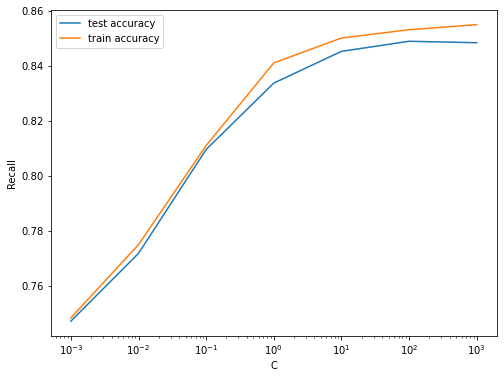

In [120]:
# plotting results for Logistic regression with L2 panelty
plt.figure(figsize=(8, 6))
plt.plot(cv_results_penalty_l2['param_C'], cv_results_penalty_l2['mean_test_score'])
plt.plot(cv_results_penalty_l2['param_C'], cv_results_penalty_l2['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Recall')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [121]:
# Final model based on best score
model=LogisticRegression(C=10,penalty="l2")
model.fit(X_train,y_train)

y_pred = model.predict(X_test)

# metrics
print(metrics.confusion_matrix(y_test, y_pred))

# accuracy
print("accuracy:", metrics.accuracy_score(y_test, y_pred))

# precision
print("precision:", metrics.precision_score(y_test, y_pred))

# recall/sensitivity
print("recall:", metrics.recall_score(y_test, y_pred))

[[8119  109]
 [ 500  256]]
accuracy: 0.932212822796082
precision: 0.7013698630136986
recall: 0.3386243386243386


**The Logistic Regresison with L2 Regularization gives an accuracy of 93%.**

## Logistic model with PCA

In [122]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [123]:
pca.fit(X_train)

PCA(random_state=42, svd_solver='randomized')

In [124]:
# Data frame with pc1 and pc2
colnames = list(X_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

PC1       PC2                 Feature
0 -0.005099  0.127165                     aon
1  0.020634 -0.053682         arpu_good_phase
2  0.023341 -0.068767       arpu_action_phase
3 -0.003262 -0.056903    onnet_mou_good_phase
4 -0.000965 -0.042420  onnet_mou_action_phase

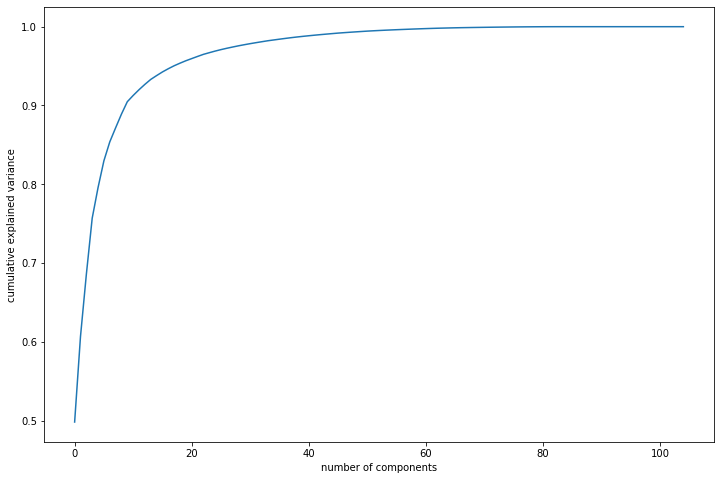

In [125]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

**25 Components explain 95% of the variance hence chossing 25 components for our modelling**

In [126]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=25)

In [127]:
# Basis transformation - getting the data onto our PCs
df_train_pca = pca_final.fit_transform(X_train)

In [128]:
#creating correlation matrix for the principal components
corrmat = np.corrcoef(df_train_pca.transpose())

In [129]:
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)

max corr: 0.007520934604462459 , min corr:  -0.006915615305902827


**We notice that the correlations are very close to zero indicating that multicollinarity has been handled**

In [130]:
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(8984, 25)

In [131]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

learner_pca = LogisticRegression(class_weight='balanced')
model_pca = learner_pca.fit(df_train_pca,y_train)

In [132]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.9'

In [133]:
# Converting y_pred to a dataframe which is an array
y_pred_2 = pd.DataFrame(y_test)
y_pred_2['final_predicted'] = pred_probs_test
# Let's see the head
y_pred_2.head()

churn  final_predicted
60217      0         0.769126
26722      0         0.471110
82411      0         0.424424
16868      0         0.163946
38631      0         0.311264

In [134]:
# Change final_predicted data type to int64 for calculations
pd.options.display.float_format = '{:,.0f}'.format
y_pred_2['final_predicted'] = y_pred_2['final_predicted'].astype(np.int64)
y_pred_2.head()

churn  final_predicted
60217      0                0
26722      0                0
82411      0                0
16868      0                0
38631      0                0

**Confusion Matrix**

In [135]:
# creating confusion matrix for test data
confusion2 = metrics.confusion_matrix(y_pred_2.churn, y_pred_2.final_predicted )
confusion2

array([[8228,    0],
       [ 756,    0]], dtype=int64)

In [136]:
# metrics
# accuracy
print("accuracy : ", metrics.accuracy_score(y_pred_2.churn, y_pred_2.final_predicted))
# precision
print("precision : ", metrics.precision_score(y_pred_2.churn, y_pred_2.final_predicted))
# recall/sensitivity
print("recall : ", metrics.recall_score(y_pred_2.churn, y_pred_2.final_predicted))

accuracy :  0.9158504007123776
precision :  0.0
recall :  0.0


**The logistic regression model with PCA has accuracy of 91.5%**

## Decision Tree Model

**Data Preparation**

In [137]:
X = HVC_df.drop(['mobile_number','churn'],axis=1)

# Putting response variable to y
y = HVC_df['churn']

In [138]:
# Splitting the data into train and test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

In [139]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Starting with random max depth as 5
dt_default = DecisionTreeClassifier(class_weight='balanced',max_depth=5)
dt_default.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5)

In [140]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# Making predictions
y_pred= dt_default.predict(X_test)

In [141]:
print(metrics.confusion_matrix(y_test, y_pred))

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

# precision
print("precision", metrics.precision_score(y_test, y_pred))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred))

[[7422  806]
 [ 128  628]]
accuracy 0.8960373998219056
precision 0.43793584379358436
recall 0.8306878306878307


In [142]:
# Importing required packages for Decision Tree visualization
from IPython.display import Image  
from six import StringIO 
from sklearn.tree import export_graphviz
import pydotplus, graphviz

# Putting features
features = list(HVC_df.columns[1:])
features

['aon',
 'arpu_good_phase',
 'arpu_action_phase',
 'onnet_mou_good_phase',
 'onnet_mou_action_phase',
 'offnet_mou_good_phase',
 'offnet_mou_action_phase',
 'roam_ic_mou_good_phase',
 'roam_ic_mou_action_phase',
 'roam_og_mou_good_phase',
 'roam_og_mou_action_phase',
 'loc_og_t2t_mou_good_phase',
 'loc_og_t2t_mou_action_phase',
 'loc_og_t2m_mou_good_phase',
 'loc_og_t2m_mou_action_phase',
 'loc_og_t2f_mou_good_phase',
 'loc_og_t2f_mou_action_phase',
 'loc_og_t2c_mou_good_phase',
 'loc_og_t2c_mou_action_phase',
 'loc_og_mou_good_phase',
 'loc_og_mou_action_phase',
 'std_og_t2t_mou_good_phase',
 'std_og_t2t_mou_action_phase',
 'std_og_t2m_mou_good_phase',
 'std_og_t2m_mou_action_phase',
 'std_og_t2f_mou_good_phase',
 'std_og_t2f_mou_action_phase',
 'std_og_mou_good_phase',
 'std_og_mou_action_phase',
 'isd_og_mou_good_phase',
 'isd_og_mou_action_phase',
 'spl_og_mou_good_phase',
 'spl_og_mou_action_phase',
 'og_others_good_phase',
 'og_others_action_phase',
 'total_og_mou_good_phase',
 '

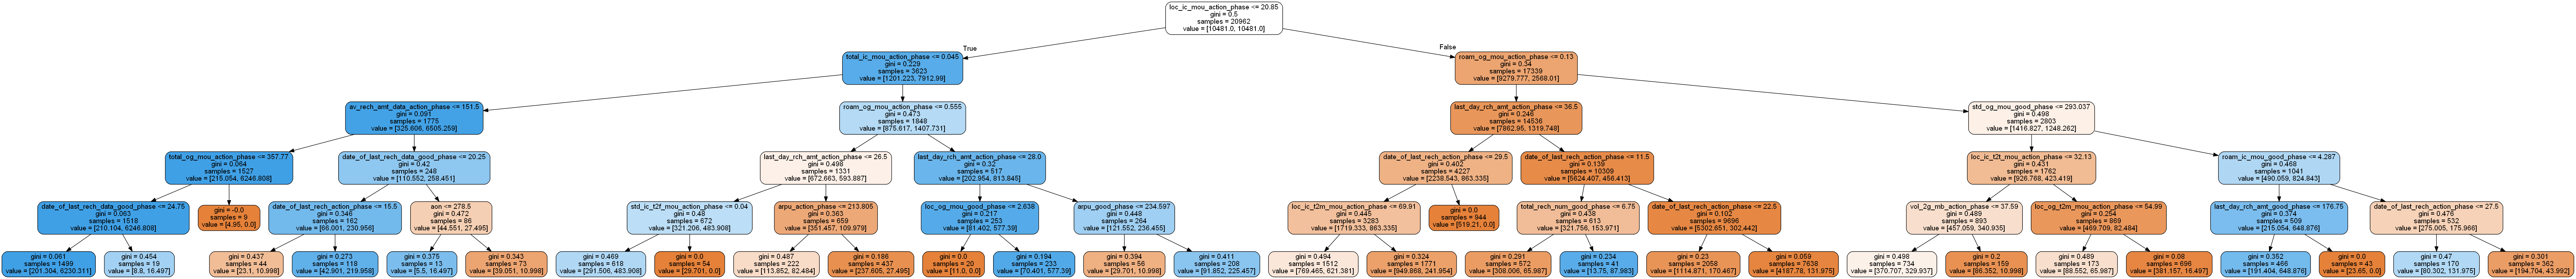

In [143]:
# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(dt_default, out_file=dot_data,feature_names = list(HVC_df.columns[1:106]) , filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

**Using Grid Search to Find Optimal Hyperparameters**

In [144]:
param_grid = {
    'max_depth': range(5, 15, 2),
    'min_samples_leaf': range(50, 250, 50),
    'min_samples_split': range(50, 250, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier(class_weight='balanced')
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          scoring="recall", cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 800 out of 800 | elapsed: 12.1min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 2),
                         'min_samples_leaf': range(50, 250, 50),
                         'min_samples_split': range(50, 250, 50)},
             scoring='recall', verbose=1)

In [145]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)

In [146]:
# Check the best estimators
print("best recall", grid_search.best_score_)
print(grid_search.best_estimator_)

best recall 0.8462698052795755
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, min_samples_leaf=100, min_samples_split=50)


**Using the best estimators to build the final Decision tree model**

In [147]:
# model with optimal hyperparameters
clf_entropy = DecisionTreeClassifier(class_weight='balanced',
                                  criterion='entropy', 
                                  random_state = 100,
                                  max_depth=9, 
                                  min_samples_leaf=100,
                                  min_samples_split=50)
clf_entropy.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=9, min_samples_leaf=100, min_samples_split=50,
                       random_state=100)

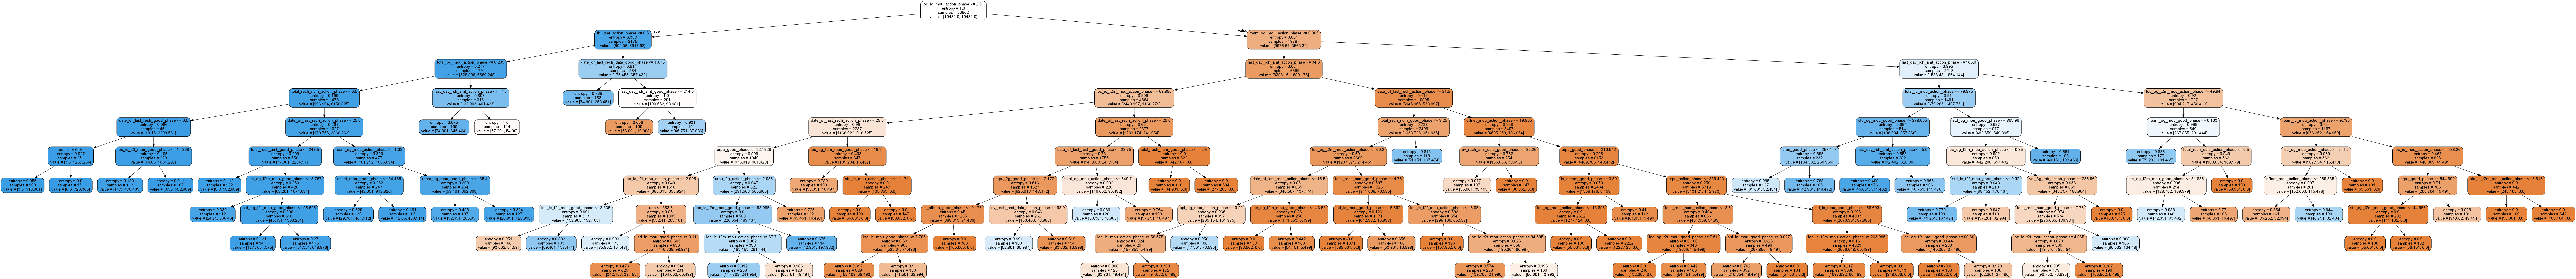

In [148]:
# plotting the tree
dot_data = StringIO()  
export_graphviz(clf_entropy, out_file=dot_data,feature_names=list(HVC_df.columns[1:106]),filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

**Accuracy**

In [149]:
clf_entropy.score(X_test,y_test)

0.8507346393588602

In [150]:
# making predictions
y_pred = clf_entropy.predict(X_test)

print(metrics.confusion_matrix(y_test, y_pred))

# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))

# precision
print("precision", metrics.precision_score(y_test, y_pred))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, y_pred))

[[7000 1228]
 [ 113  643]]
accuracy 0.8507346393588602
precision 0.3436664885088188
recall 0.8505291005291006


**The Decision Tree model after tuning provided the recall value of 85.05%**

## Random Forest model

**Data Preparation**   

In [151]:
X = HVC_df.drop(['mobile_number','churn'],axis=1)

# Putting response variable to y
y = HVC_df['churn']

**Train Test Split**

In [152]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7,test_size=0.3,random_state=100)

**Random Forrest - Model Building**

In [153]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [154]:
# Predictions
predictions = rfc.predict(X_test)

**Metrics**

In [155]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, predictions))

# accuracy
print("accuracy", metrics.accuracy_score(y_test, predictions))

# precision
print("precision", metrics.precision_score(y_test, predictions))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, predictions))

[[8116  112]
 [ 320  436]]
accuracy 0.9519145146927872
precision 0.7956204379562044
recall 0.5767195767195767


**Grid Search to Find Optimal Hyperparameters**

In [156]:
n_folds = 3

param_grid = {
    'max_depth': [6,8,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [400,600,800], 
    'max_features': [10,20,30]
}

rf = RandomForestClassifier(class_weight='balanced')
rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                    cv=n_folds, n_jobs = -1,verbose = 1,
                   scoring="recall")
rf.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 47.9min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 124.0min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8, 10], 'max_features': [10, 20, 30],
                         'min_samples_leaf': range(100, 400, 200),
                         'min_samples_split': range(200, 500, 200),
                         'n_estimators': [400, 600, 800]},
             scoring='recall', verbose=1)

In [157]:
print('Best estimators: ',rf.best_score_," ",rf.best_params_)

Best estimators:  0.7995798874197328   {'max_depth': 8, 'max_features': 30, 'min_samples_leaf': 100, 'min_samples_split': 400, 'n_estimators': 600}


In [158]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=10,
                             min_samples_leaf=100, 
                             min_samples_split=400,
                             max_features=30,
                             n_estimators=800,class_weight='balanced')

In [159]:
rfc.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=30,
                       min_samples_leaf=100, min_samples_split=400,
                       n_estimators=800)

In [160]:
# predict
predictions = rfc.predict(X_test)

In [161]:
print(metrics.confusion_matrix(y_test, predictions))

# accuracy
print("accuracy", metrics.accuracy_score(y_test, predictions))

# precision
print("precision", metrics.precision_score(y_test, predictions))

# recall/sensitivity
print("recall", metrics.recall_score(y_test, predictions))

[[7443  785]
 [ 112  644]]
accuracy 0.9001558325912734
precision 0.45066480055983205
recall 0.8518518518518519


**RESULT: The Random Forest model after tuning provided the recall value of 83.7%**

### Model Summary

Below tables provides the results for different models:

| Model Name | Consider Class Imbalance | Explains through variables | Recall Score | Precision Score |
| --- | --- | --- | --- | --- |
| Logistic Regression Model with RFE | Y | Y | 0.79 | 0.41 |
| Logistic Regression Model with L1/L2 Regularization | Y | N | 0.33 | 0.70 |
| Decision Tree Model | Y | Y | 0.83 | 0.44 |
| Random Forest Model | Y | N | 0.85 | 0.45 |

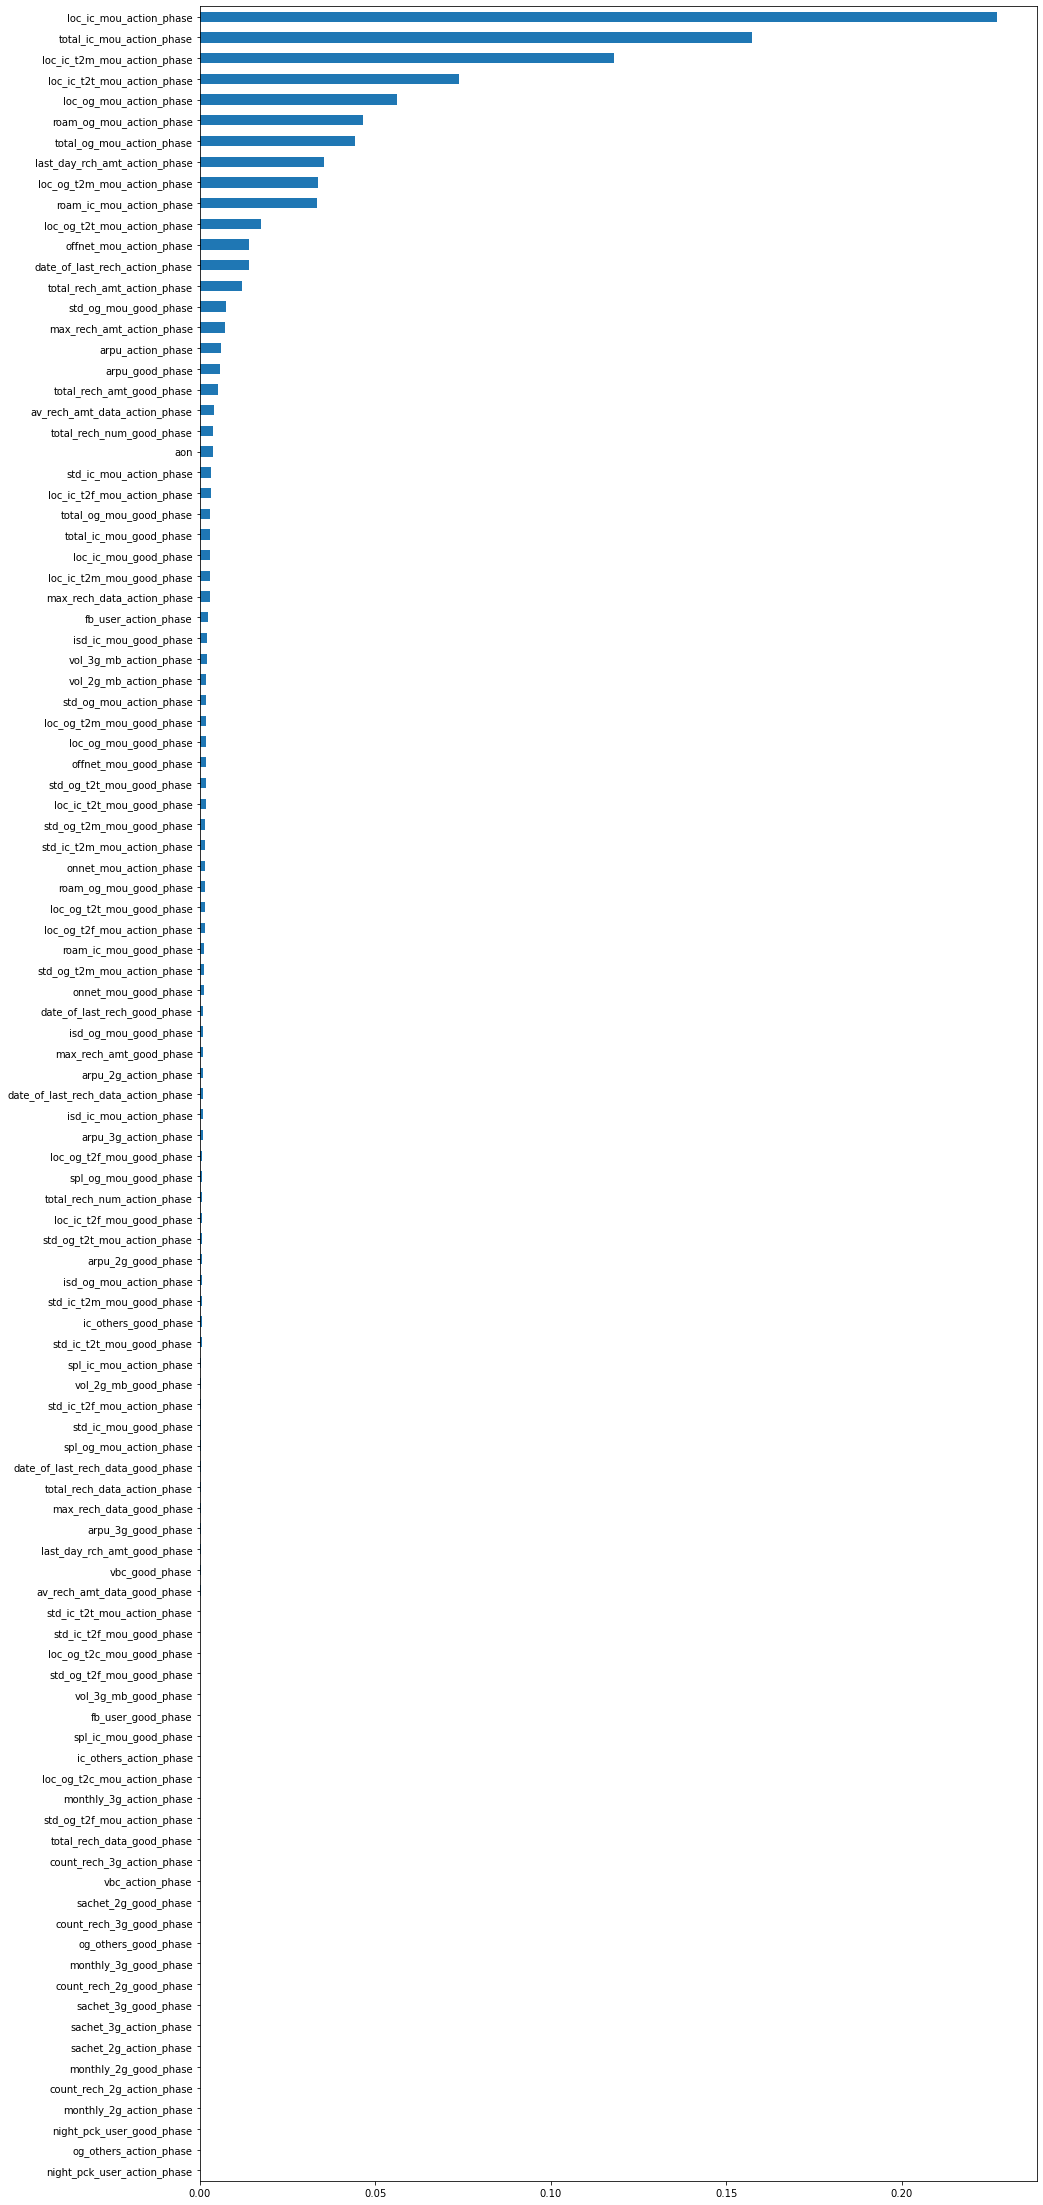

In [162]:
plt.figure(figsize=(15,40))
feature_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feature_importances.nlargest(len(X.columns)).sort_values().plot(kind='barh', align='center')

# Conclusion
We recommend to use the model for <b>Random Forest</b> both for Prediction and explanation. The Random forest has a good Recall score and is easier to understand and explain it to the customers.



# Important churn indicators

- loc_ic_mou_action_phase - Local Incoming Minutes Of Usage in Action Phase

- total_ic_mou_action_phase - Total Incoming Minutes Of Usage in Action Phase

- loc_ic_t2m_mou_action_phase - Local Incoming Operator T to other operator mobile minutes of usage in Action Phase

- loc_og_mou_action_phase - Local Outgoing Minutes Of Usage in Action Phase

- loc_ic_t2t_mou_action_phase - Local Incoming Operator T to T, i.e. within same operator Minutes of Usage in Action Phase

- loc_og_t2m_mou_action_phase - Local Outgoing Operator T to other operator mobile Minutes Of Usage in Action Phase

- total_og_mou_action_phase - Total Outgoing Minutes Of Usage in Action Phase

- roam_og_mou_action_phase - Roaming Outgoing Minutes Of Usage in Action Phase

- last_day_rch_amt_action_phase - Last Day Recharge Amount In Action Phase

- roam_ic_mou_action_phase - Roaming Incoming Minutes Of Usage in Action Phase

- loc_og_t2t_mou_action_phase - Local Outgoing Operator T to T, i.e. within same operator Minutes of Usage in Action Phase

- total_rech_amt_action_phase - Total Recharge Amount In Action Phase

- max_rech_amt_action_phase - Maximum Recharge Amount In Action Phase


## Strategies to manage customer churn

The telecom company should pay close attention to drop in MoU, ARPU and data usage (2g and 3g) month over month. The company should track these numbers week over week. Since billing cycles are typically monthly, a drop in usage numbers will give the company time to react when tracked at weekly level.

Get in touch with these cusotmers to find out what is affecting their experience. Perhaps, offer them coupons or other incentives to continue to use the services, while the company fixes the issues reported.

Marketing team must come up with campaigns which targeting high value customers.